AdaBnn: Redes Neuronales Binarizadas entrenadas mediante aprendizaje estructural adaptativo
===


In [0]:
#@title Python header
# -*- coding: utf-8 -*-
"""AdaBnn model for Keras.

# Reference:

- [AdaBnn: Binarized Neural Networks trained through Adaptive Structural Learning](TODO)

Adapted from code contributed by wilmeragsgh.
"""

## Especificaciones del entorno

In [0]:
#@title Sistema operativo
!cat /etc/*-release

DISTRIB_ID=Ubuntu
DISTRIB_RELEASE=17.10
DISTRIB_CODENAME=artful
DISTRIB_DESCRIPTION="Ubuntu 17.10"
NAME="Ubuntu"
VERSION="17.10 (Artful Aardvark)"
ID=ubuntu
ID_LIKE=debian
PRETTY_NAME="Ubuntu 17.10"
VERSION_ID="17.10"
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
VERSION_CODENAME=artful
UBUNTU_CODENAME=artful


In [0]:
#@title Memoria RAM
!cat /proc/meminfo

MemTotal:       13341832 kB
MemFree:         1780524 kB
MemAvailable:   12415672 kB
Buffers:          125532 kB
Cached:         10430084 kB
SwapCached:            0 kB
Active:          1954188 kB
Inactive:        8904108 kB
Active(anon):     372068 kB
Inactive(anon):   184528 kB
Active(file):    1582120 kB
Inactive(file):  8719580 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:              3028 kB
Writeback:             0 kB
AnonPages:        302716 kB
Mapped:           126432 kB
Shmem:            253924 kB
Slab:             613100 kB
SReclaimable:     586864 kB
SUnreclaim:        26236 kB
KernelStack:        3312 kB
PageTables:         4144 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6670916 kB
Committed_AS:    1493596 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
AnonHugePages:         0 kB
HugePages_Total: 

In [0]:
#@title CPU
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2300.000
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc eagerfpu pni pclmulqdq ssse3 fma cx16 sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm kaiser fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms xsaveopt
bugs		:
bogomips	: 4600.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management:

processor	: 1
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2300.000
cache s

In [0]:
#@title GPU 
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10061197746253946360, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11288962663
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10867036594916694074
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [0]:
#@title Configuración del uso de GPU
# Setting up GPU usage
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

# Configuring GPU auto growth
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

Found GPU at: /device:GPU:0


In [0]:
#@title Version de python usada
import sys
print(sys.version)

3.6.3 (default, Oct  3 2017, 21:45:48) 
[GCC 7.2.0]


## Bibliotecas necesarias

In [0]:
#@title
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


import pandas as pd
import os
import time
import warnings
import random
import numpy as np
import keras
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('bmh')
from datetime import datetime

from keras import backend as K

from keras.models import Model

from google.colab import files

from keras.layers import Activation
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import concatenate
from keras.layers import Flatten

from keras.callbacks import EarlyStopping

from keras.initializers import Initializer

from keras.optimizers import SGD

from keras.constraints import max_norm

from keras.engine.topology import get_source_inputs

from keras.utils.data_utils import get_file

from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import _obtain_input_shape

from keras.utils.generic_utils import deserialize_keras_object
from keras.utils.generic_utils import serialize_keras_object


from keras.engine import Layer
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import StratifiedKFold
print('última actualizacion en: ', str(datetime.now()))

Using TensorFlow backend.


última actualizacion en:  2018-05-22 15:42:16.093874


## Funciones necesarias

In [0]:
#@title Funciones de costo
def F(y_true, y_pred):
    return K.mean(K.log( 1 + K.exp(1. - y_true * y_pred)), axis=-1)
print('Funciones de costo declaradas, última actualizacion en: ', str(datetime.now()))

Funciones de costo declaradas, última actualizacion en:  2018-05-22 15:42:20.171359


In [0]:
#@title Funciones de regularización
lmbda = 10**-4
beta = 0

def RademacherComplexity(weight_matrix):
    M = weight_matrix.shape[0].value
    radNoise = K.variable([[random.choice([-1,1]) for k in range(M)]]).value()
    weight_matrix_sum = K.variable([K.sum(weight_matrix, axis=1)]).value()
    R = (1 / M) * K.dot(radNoise,K.transpose(weight_matrix_sum))
    R = (lmbda * R + beta) * (0.01 * K.sum(K.abs(weight_matrix)))
    return R
print('Funciones de regularización declaradas, última actualizacion en: ', str(datetime.now()))

Funciones de regularización declaradas, última actualizacion en:  2018-05-22 15:42:21.848978


In [0]:
#@title Funciones de inicialización
def _compute_fans(shape, data_format='channels_last'):
    """Computes the number of input and output units for a weight shape.
    # Arguments
        shape: Integer shape tuple.
        data_format: Image data format to use for convolution kernels.
            Note that all kernels in Keras are standardized on the
            `channels_last` ordering (even when inputs are set
            to `channels_first`).
    # Returns
        A tuple of scalars, `(fan_in, fan_out)`.
    # Raises
        ValueError: in case of invalid `data_format` argument.
    """
    if len(shape) == 2:
        fan_in = shape[0]
        fan_out = shape[1]
    elif len(shape) in {3, 4, 5}:
        # Assuming convolution kernels (1D, 2D or 3D).
        # TH kernel shape: (depth, input_depth, ...)
        # TF kernel shape: (..., input_depth, depth)
        if data_format == 'channels_first':
            receptive_field_size = np.prod(shape[2:])
            fan_in = shape[1] * receptive_field_size
            fan_out = shape[0] * receptive_field_size
        elif data_format == 'channels_last':
            receptive_field_size = np.prod(shape[:-2])
            fan_in = shape[-2] * receptive_field_size
            fan_out = shape[-1] * receptive_field_size
        else:
            raise ValueError('Invalid data_format: ' + data_format)
    else:
        # No specific assumptions.
        fan_in = np.sqrt(np.prod(shape))
        fan_out = np.sqrt(np.prod(shape))
    return fan_in, fan_out

def sign_binarization(x):
    return K.sign(x)
    #if random.uniform(0,1) <= hard_sigmoid:
    #    return 1
    #else:
    #    return -1

def stochastic_binarization(x):
    hard_sigmoid = K.clip((x+1.)/2,0,1)
    tensor_bool = K.less_equal(K.random_uniform(shape=x.shape,minval=0.0,maxval=1.0),hard_sigmoid)
    tensor_float = K.cast(tensor_bool,dtype='float32')
    tensor_float_comp = tensor_float + K.constant(-1,shape=tensor_float.shape,dtype='float32')
    return tensor_float + tensor_float_comp
    #if random.uniform(0,1) <= hard_sigmoid:
    #    return 1
    #else:
    #    return -1

class BinaryUniform(Initializer):
    """Initializer that generates a binarized tensor from a uniform distribution.
    # Arguments
        minval: A python scalar or a scalar tensor. Lower bound of the range
          of random values to generate.
        maxval: A python scalar or a scalar tensor. Upper bound of the range
          of random values to generate.  Defaults to 1 for float types.
        seed: A Python integer. Used to seed the random generator.
    """

    def __init__(self, minval=-0.05, maxval=0.05, seed=None):
        self.minval = minval
        self.maxval = maxval
        self.seed = seed

    def __call__(self, shape, dtype=None):
    	value = K.random_uniform(shape, -1, 1,
    		                     dtype=dtype, seed=self.seed)
    	return sign_binarization(value)

    def get_config(self):
        return {
            'minval': self.minval,
            'maxval': self.maxval,
            'seed': self.seed,
        }


class BinaryGlorot_uniform(Initializer):
    """Binarized Glorot uniform initializer, also called Xavier uniform initializer.
    It draws samples from a uniform distribution within [-limit, limit]
    where `limit` is `sqrt(6 / (fan_in + fan_out))`
    where `fan_in` is the number of input units in the weight tensor
    and `fan_out` is the number of output units in the weight tensor.
    # Arguments
        seed: A Python integer. Used to seed the random generator.
    # Returns
        An initializer.
    # References
        Glorot & Bengio, AISTATS 2010
        http://jmlr.org/proceedings/papers/v9/glorot10a/glorot10a.pdf
    """

    def __init__(self, scale=1.0,
                 mode='fan_avg',
                 distribution='uniform',
                 seed=None):
        self.scale = scale
        self.mode = mode
        self.distribution = distribution
        self.seed = seed

    def __call__(self, shape, dtype=None):
        fan_in, fan_out = _compute_fans(shape)
        scale = self.scale
        scale /= max(1., float(fan_in + fan_out) / 2)
        limit = np.sqrt(3. * scale)
        value = K.random_uniform(shape, -limit, limit,
                                 dtype=dtype, seed=self.seed)
        return sign_binarization(value)

    def get_config(self):
        return {
            'scale': self.scale,
            'mode': self.mode,
            'distribution': self.distribution,
            'seed': self.seed
        }
print('Funciones de inicialización declaradas, última actualizacion en: ', str(datetime.now()))

Funciones de inicialización declaradas, última actualizacion en:  2018-05-22 15:42:22.949028


In [0]:
#@title Funciones de activación
# Activations
def sign_binarization(x):
    return K.sign(x)
    #if random.uniform(0,1) <= hard_sigmoid:
    #    return 1
    #else:
    #    return -1

def stochastic_binarization(x):
    hard_sigmoid = K.clip((x+1.)/2,0,1)
    tensor_bool = K.less_equal(K.random_uniform(shape=x.shape,minval=0.0,maxval=1.1),hard_sigmoid)
    tensor_float = K.cast(tensor_bool,dtype='float32')
    tensor_float_comp = tensor_float + K.constant(-1,shape=tensor_float.shape,dtype='float32')
    return tensor_float + tensor_float_comp
    #if random.uniform(0,1) <= hard_sigmoid:
    #    return 1
    #else:
    #    return -1

def BinaryRelu(x, alpha=0., max_value=None):
    value = K.relu(x, alpha=alpha, max_value=max_value)
    return sign_binarization(value)
print('Funciones de activación declaradas, última actualizacion en: ', str(datetime.now()))

Funciones de activación declaradas, última actualizacion en:  2018-05-22 15:42:23.808637


In [0]:
#@title Funciones de preprocesamiento
import cv2
from skimage.feature import hog
from sklearn.preprocessing import label_binarize

# image utils
def image_to_feature_vector(images):
	images_hc = [cv2.calcHist([x],[0,1,2],None,[8,8,8],[0,256,0,256,0,256]).flatten() for x in images]
	images_hog = [hog(cv2.cvtColor(x, cv2.COLOR_BGR2GRAY),9,(8,8),(3,3)) for x in images]
	images_pre = np.append(images_hc,images_hog,axis=1)
	return images_pre

# preprocesamiento para cifar-10
def prep_cifar_binary(label0,label1,x_train,y_train,x_test,y_test):
    i = np.append(np.where(y_train == [label0])[0],np.where(y_train == [label1])[0])
    x_train = x_train[i]
    x_train = image_to_feature_vector(x_train)
    y_train = label_binarize(y_train[i], classes = [label0,label1])
    i = np.append(np.where(y_test == [label0])[0],np.where(y_test == [label1])[0])
    x_test = x_test[i]
    x_test = image_to_feature_vector(x_test)
    y_test = label_binarize(y_test[i], classes = [label0,label1])
    return x_train,y_train,x_test,y_test
  
def prep_cifar_multi(x_train,y_train,x_test,y_test,num_classes=10):
  x_train = image_to_feature_vector(x_train)
  x_test = image_to_feature_vector(x_test)
  y_train = keras.utils.to_categorical(y_train, num_classes)
  y_test = keras.utils.to_categorical(y_test, num_classes)
  return x_train,y_train,x_test,y_test
  
  
def prep_mnist_multi(x_train,y_train,x_test,y_test):
  x_train = x_train.reshape(60000, 784)
  x_test = x_test.reshape(10000, 784)
  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')
  x_train /= 255
  x_test /= 255
  y_train = keras.utils.to_categorical(y_train, 10)
  y_test = keras.utils.to_categorical(y_test, 10)
  return x_train,y_train,x_test,y_test

print('Funciones de preprocesamiento declaradas, última actualizacion en: ', str(datetime.now()))

Funciones de preprocesamiento declaradas, última actualizacion en:  2018-05-22 15:42:26.001016


In [0]:
#@title Función de cálculo de intervalo de confianza
def conf_interval(samples,accuracy,confidence_level):
  if(confidence_level == 0.95):
    Z = 1.96
    min_val = ((2*samples*accuracy) + (Z**2) - (Z*np.sqrt(Z**2 + (4*samples*accuracy) - (4*samples*accuracy**2)))) / (2*(samples+(Z**2)))
    max_val = ((2*samples*accuracy) + (Z**2) + (Z*np.sqrt(Z**2 + (4*samples*accuracy) - (4*samples*accuracy**2)))) / (2*(samples+(Z**2)))
    return min_val, max_val

## Carga de los datos

In [0]:
#@title 
import tensorflow as tf
(cifar_x_train, cifar_y_train), (cifar_x_test, cifar_y_test) = tf.keras.datasets.cifar10.load_data()
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = tf.keras.datasets.mnist.load_data(path='mnist.npz')
print('Datos cargados, última actualizacion en: ', str(datetime.now()))

Datos cargados, última actualizacion en:  2018-05-22 15:44:37.724247


## Definición de los modelos desarollados (AdaBnn y AdaNet)

In [0]:
#@title Definición del modelo AdaBnn
def AdaBnn(x_train,y_train,conf,classes=2,verbose=1):
    """Instatiates the AdaBnn architecture.

     # Arguments
        x_train: feature matrix for AdaNet framework.
        y_train: label matrix for AdaNet framework.
        conf: configuration parameters for adanet
            conf = dict({
                'network': {
                    'activation': 'relu',
                    'output_activation': 'sigmoid',
                    'optimizer': keras.optimizers.Adam(lr=0.0001),
                    'loss': 'binary_crossentropy',
                },
                'training':{
                    'batch_size': 32,
                    'epochs': 1,
                },
                'adanet':{
                    'B': 150,#3,
                    'T': 20#5
                    'delta': 1.01
                }
            })
        classes: number of classes to predict
        verbose: if 1: track the status of the training, 
            if 2: track also the timing for each part.
    # Returns
        A Keras model instance."""
    activation = conf['network']['activation']
    output_activation = conf['network']['output_activation']
    optimizer = conf['network']['optimizer']
    loss = conf['network']['loss']
    
    batch_size = conf['training']['batch_size']
    epochs = conf['training']['epochs']
    
    B = conf['adabnn']['B']
    T = conf['adabnn']['T']
    delta = conf['adabnn']['delta']
    seed = conf['adabnn']['seed']

    if classes == 2:
        output_shape = 1
    if classes > 2:
        output_shape = classes

    H = {}
    perf = []
    input_shape = x_train.shape[1::]
    inp = Input(shape=input_shape,name = 'input_layer')
    if len(input_shape) > 1:
        raise ValueError('The input data features'
                         'will be flatten into one dimension'
                         'next to the input layer')
        prep = Flatten(name='flat')(inp)
        h11 = Dense(B,
                    activation=activation,
                    kernel_regularizer=RademacherComplexity,
                    kernel_initializer=BinaryGlorot_uniform(seed=seed),
                    use_bias=False,
                    name = 'h11')(prep)
        H[0] = ['h11']
    else:
        h11 = Dense(B,
                    activation=activation,
                    kernel_regularizer=RademacherComplexity,
                    kernel_initializer=BinaryGlorot_uniform(seed=seed),
                    use_bias=False,
                    name = 'h11')(inp)
        H[0] = ['h11']
    out = Dense(output_shape,
                activation=output_activation,
                kernel_regularizer=RademacherComplexity,
                kernel_initializer=BinaryGlorot_uniform(seed=seed),
                use_bias=False,
                name = 'output_layer')(h11)
    model = Model(inp,out)
    depth = 1
    for t in range(0,T):
        H1 = H.copy()
        H2 = H.copy()
        if verbose in [1,2]: print('[INFO] Iteration: ',t + 1,'\n[INFO] Preparing H')
        for depth_h1 in range(1,depth+1):
            if depth_h1 == 1:
                h11_name = 'h' + str(depth_h1) + str(t+2)
                if verbose in [1,2]: print('[INFO] Adding layer node: ',h11_name)
                h1_layers = [Dense(B,
                                   activation=activation,
                                   kernel_regularizer=RademacherComplexity,
                                   use_bias=False,
                                   name=h11_name)(model.get_layer('input_layer').output)]
                H1[t+1] = [h11_name]
            else:
                conc = [model.get_layer(h).output for h in [h[depth_h1-2] for n,h in H.items() if len(h) >= (depth_h1-1)] ]
                conc.append(h1_layers[depth_h1-2])
                h22_name = 'h' + str(depth_h1) + str(t+2)
                if verbose in [1,2]: print('[INFO] Adding layer node: ',h22_name)
                h1_layers.append(Dense(B,
                                       activation=activation,
                                       kernel_regularizer=RademacherComplexity,
                                       kernel_initializer=BinaryGlorot_uniform(seed=seed),
                                       use_bias=False,
                                       name=h22_name)(concatenate(conc)))
                H1[t+1].append(h22_name)
        conc1 = [model.get_layer(y[-1]).output for (k,y) in H.items()]
        conc1.append(h1_layers[-1])
        out = Dense(output_shape,
                    activation=output_activation,
                    kernel_regularizer=RademacherComplexity,
                    kernel_initializer=BinaryGlorot_uniform(seed=seed),
                    use_bias=False,
                    name='output_layer')(concatenate(conc1))
        mo1 = Model(inputs=inp,
                    outputs=out)
        if verbose == 2:
            t1 = time.time()
            print('[TIMING] Defining layers and stacking them', t1 - t0)
        mo1.compile(optimizer=optimizer,
                    loss=loss,
                    metrics=['accuracy'])
        if verbose == 2:
            t2 = time.time()
            print('[TIMING] Compilation of the model', t2-t1)
        mo1.fit(x_train,
                y_train,
                batch_size=batch_size,
                epochs=epochs,
                shuffle=True,
                verbose=0)
        if verbose == 2:
            t3 = time.time()
            print('[TIMING] Fitting of the model', t3-t2)
        loss_h1,acc_h1 = mo1.evaluate(x_train,
                                      y_train,
                                      batch_size=batch_size,
                                      verbose=0)
        if verbose == 2:
            t4 = time.time()
            print('[TIMING] Evaluation of the model', t4-t3)

        if verbose in [1,2]: print('[INFO] Preparing Hprime')
        for depth_h2 in range(1,depth+2):
            if depth_h2 == 1:
                h11_name = 'h' + str(depth_h2) + str(t+2)
                if verbose in [1,2]: print('[INFO] Adding layer node: ',h11_name)
                h2_layers = [Dense(B,
                                   activation=activation,
                                   kernel_regularizer=RademacherComplexity,
                                   use_bias=False,
                                   name=h11_name)(model.get_layer('input_layer').output)]
                H2[t+1] = [h11_name]
            else:
                conc = [model.get_layer(h).output for h in [h[depth_h1-2] for n,h in H.items() if len(h) >= (depth_h1-1)] ]
                conc.append(h2_layers[depth_h2-2])
                h22_name = 'h' + str(depth_h2) + str(t+2)
                if verbose in [1,2]: print('[INFO] Adding layer node: ',h22_name)
                h2_layers.append(Dense(B,
                                       activation=activation,
                                       kernel_regularizer=RademacherComplexity,
                                       use_bias=False,
                                       name=h22_name)(concatenate(conc)))
                H2[t+1].append(h22_name)
        conc2 = [model.get_layer(y[-1]).output for (k,y) in H.items()]
        conc2.append(h2_layers[-1])
        out = Dense(output_shape,
                    activation=output_activation,
                    kernel_regularizer=RademacherComplexity,
                    kernel_initializer=BinaryGlorot_uniform(seed=seed),
                    use_bias=False,
                    name='output_layer')(concatenate(conc2))
        mo2 = Model(inputs=inp,
                    outputs=out)
        if verbose == 2:
            t5 = time.time()
            print('[TIMING] Defining layers and stacking them', t5 - t4)
        mo2.compile(optimizer=optimizer,
                    loss=loss,
                    metrics=['accuracy'])
        if verbose == 2:
            t6 = time.time()
            print('[TIMING] Compilation of the model', t6 - t5)
        mo2.fit(x_train,
                y_train,
                batch_size=batch_size,
                epochs=epochs,
                shuffle=True,
                verbose=0)
        if verbose == 2:
            t7 = time.time()
            print('[TIMING] Fitting of the model', t7 - t6)
        loss_h2,acc_h2 = mo2.evaluate(x_train,
                                      y_train,
                                      batch_size=batch_size,
                                      verbose=0)
        if verbose == 2:
            t8 = time.time()
            print('[TIMING] Evaluation of the model', t8 - t7)
        if loss_h1 < loss_h2:
            model = mo1
            H = H1
            loss_selected = loss_h1
            acc_selected = acc_h1
            if verbose in [1,2]: print('[INFO] H was selected')
        elif loss_h1 > loss_h2:
            if verbose in [1,2]: print('[INFO] Hprime was selected')
            model = mo2
            H = H2
            loss_selected = loss_h2
            acc_selected = acc_h2
            depth = depth + 1
        else:
            model = mo1
            H = H1
            loss_selected = loss_h1
            acc_selected = acc_h1
            if verbose in [1,2]: print('[INFO] Choosing H, without improving the loss function')
            break
        perf.append({
            "iteración": t + 1,
            "precisión": acc_selected,
            "función de costo": loss_selected
        })
    return model,perf
print('Modelo AdaBnn declarado, última actualizacion en: ', str(datetime.now()))  

Modelo AdaBnn declarado, última actualizacion en:  2018-05-21 19:29:46.320276


In [0]:
#@title Definición del modelo AdaNet
def AdaNet(x_train,y_train,conf,classes=2,verbose=1):
    """Instatiates the AdaNet architecture.

    # Arguments
        x_train: feature matrix for AdaNet framework.
        y_train: label matrix for AdaNet framework.
        conf: configuration parameters for adanet
            conf = dict({
                'network': {
                    'activation': 'relu',
                    'output_activation': 'sigmoid',
                    'optimizer': keras.optimizers.Adam(lr=0.0001),
                    'loss': 'binary_crossentropy',
                },
                'training':{
                    'batch_size': 32,
                    'epochs': 1,
                },
                'adanet':{
                    'B': 150,#3,
                    'T': 20#5
                    'delta': 1.01
                }
            })
        classes: number of classes to predict
        verbose: if 1: track the status of the training, 
            if 2: track also the timing for each part.
    # Returns
        A Keras model instance."""
    activation = conf['network']['activation']
    output_activation = conf['network']['output_activation']
    optimizer = conf['network']['optimizer']
    loss = conf['network']['loss']
    
    batch_size = conf['training']['batch_size']
    epochs = conf['training']['epochs']
    
    B = conf['adanet']['B']
    T = conf['adanet']['T']
    delta = conf['adanet']['delta']

    if classes == 2:
        output_shape = 1
    if classes > 2:
        output_shape = classes
    
    H = {}
    perf = []
    input_shape = x_train.shape[1::]
    inp = Input(shape=input_shape,name = 'input_layer')
    if len(input_shape) > 1:
        raise ValueError('The input data features'
                         'will be flatten into one dimension'
                         'next to the input layer')
        prep = Flatten(name='flat')(inp)
        h11 = Dense(B,
                    activation=activation,
                    kernel_regularizer=RademacherComplexity,
                    kernel_constraint=max_norm(delta),
                    use_bias=False,
                    name = 'h11')(prep)
        H[0] = ['h11']
    else:
        h11 = Dense(B,
                    activation=activation,
                    kernel_regularizer=RademacherComplexity,
                    kernel_constraint=max_norm(delta),
                    use_bias=False,
                    name = 'h11')(inp)
        H[0] = ['h11']
    out = Dense(output_shape,
                activation=output_activation,
                kernel_regularizer=RademacherComplexity,
                kernel_constraint=max_norm(delta),
                use_bias=False,
                name = 'output_layer')(h11)
    model = Model(inp,out)
    depth = 1
    for t in range(0,T):
        H1 = H.copy()
        H2 = H.copy()
        if verbose in [1,2]: print('[INFO] Iteration: ',t + 1,'\n[INFO] Preparing H')
        for depth_h1 in range(1,depth+1):
            if depth_h1 == 1:
                h11_name = 'h' + str(depth_h1) + str(t+2)
                if verbose in [1,2]: print('[INFO] Adding layer node: ',h11_name)
                h1_layers = [Dense(B,
                                   activation=activation,
                                   kernel_regularizer=RademacherComplexity,
                                   kernel_constraint=max_norm(delta),
                                   use_bias=False,
                                   name=h11_name)(model.get_layer('input_layer').output)]
                H1[t+1] = [h11_name]
            else:
                conc = [model.get_layer(h).output for h in [h[depth_h1-2] for n,h in H.items() if len(h) >= (depth_h1-1)] ]
                conc.append(h1_layers[depth_h1-2])
                h22_name = 'h' + str(depth_h1) + str(t+2)
                if verbose in [1,2]: print('[INFO] Adding layer node: ',h22_name)
                h1_layers.append(Dense(B,
                                       activation=activation,
                                       kernel_regularizer=RademacherComplexity,
                                       kernel_constraint=max_norm(delta),
                                       use_bias=False,
                                       name=h22_name)(concatenate(conc)))
                H1[t+1].append(h22_name)
        conc1 = [model.get_layer(y[-1]).output for (k,y) in H.items()]
        conc1.append(h1_layers[-1])
        out = Dense(output_shape,
                    activation=output_activation,
                    kernel_regularizer=RademacherComplexity,
                    kernel_constraint=max_norm(delta),
                    use_bias=False,
                    name='output_layer')(concatenate(conc1))
        mo1 = Model(inputs=inp,
                    outputs=out)
        if verbose == 2:
            t1 = time.time()
            print('[TIMING] Defining layers and stacking them', t1 - t0)
        mo1.compile(optimizer=optimizer,
                    loss=loss,
                    metrics=['accuracy'])
        if verbose == 2:
            t2 = time.time()
            print('[TIMING] Compilation of the model', t2-t1)
        mo1.fit(x_train,
                y_train,
                batch_size=batch_size,
                epochs=epochs,
                shuffle=True,
                verbose=0,
                callbacks=[EarlyStopping(monitor='loss')])
        if verbose == 2:
            t3 = time.time()
            print('[TIMING] Fitting of the model', t3-t2)
        loss_h1,acc_h1 = mo1.evaluate(x_train,
                                      y_train,
                                      batch_size=batch_size,
                                      verbose=0)
        if verbose == 2:
            t4 = time.time()
            print('[TIMING] Evaluation of the model', t4-t3)
        if verbose in [1,2]: print('[INFO] Preparing Hprime')
        for depth_h2 in range(1,depth+2):
            if depth_h2 == 1:
                h11_name = 'h' + str(depth_h2) + str(t+2)
                if verbose in [1,2]: print('[INFO] Adding layer node: ',h11_name)
                h2_layers = [Dense(B,
                                   activation=activation,
                                   kernel_regularizer=RademacherComplexity,
                                   kernel_constraint=max_norm(delta),
                                   use_bias=False,
                                   name=h11_name)(model.get_layer('input_layer').output)]
                H2[t+1] = [h11_name]
            else:
                conc = [model.get_layer(h).output for h in [h[depth_h1-2] for n,h in H.items() if len(h) >= (depth_h1-1)] ]
                conc.append(h2_layers[depth_h2-2])
                h22_name = 'h' + str(depth_h2) + str(t+2)
                if verbose in [1,2]: print('[INFO] Adding layer node: ',h22_name)
                h2_layers.append(Dense(B,
                                       activation=activation,
                                       kernel_regularizer=RademacherComplexity,
                                       kernel_constraint=max_norm(delta),
                                       use_bias=False,
                                       name=h22_name)(concatenate(conc)))
                H2[t+1].append(h22_name)
        conc2 = [model.get_layer(y[-1]).output for (k,y) in H.items()]
        conc2.append(h2_layers[-1])
        out = Dense(output_shape,
                    activation=output_activation,
                    kernel_regularizer=RademacherComplexity,
                    kernel_constraint=max_norm(delta),
                    use_bias=False,
                    name='output_layer')(concatenate(conc2))
        mo2 = Model(inputs=inp,
                    outputs=out)
        if verbose == 2:
            t5 = time.time()
            print('[TIMING] Defining layers and stacking them', t5 - t4)
        mo2.compile(optimizer=optimizer,
                    loss=loss,
                    metrics=['accuracy'])
        if verbose == 2:
            t6 = time.time()
            print('[TIMING] Compilation of the model', t6 - t5)
        mo2.fit(x_train,
                y_train,
                batch_size=batch_size,
                epochs=epochs,
                shuffle=True,
                verbose=0,
                callbacks=[EarlyStopping(monitor='loss')])
        if verbose == 2:
            t7 = time.time()
            print('[TIMING] Fitting of the model', t7 - t6)
        loss_h2,acc_h2 = mo2.evaluate(x_train,
                                      y_train,
                                      batch_size=batch_size,
                                      verbose=0)
        if verbose == 2:
            t8 = time.time()
            print('[TIMING] Evaluation of the model', t8 - t7)
        if loss_h1 < loss_h2:
            model = mo1
            H = H1
            acc_selected = acc_h1
            loss_selected = loss_h1
            if verbose in [1,2]: print('[INFO] H was selected')
        elif loss_h1 > loss_h2:
            if verbose in [1,2]: print('[INFO] Hprime was selected')
            model = mo2
            H = H2
            acc_selected = acc_h2
            loss_selected = loss_h2
            depth = depth + 1
        else:
            model = mo1
            H = H1
            acc_selected = acc_h1
            loss_selected = loss_h1
            if verbose in [1,2]: print('[INFO] Choosing H, without improving the loss function')
            break
        perf.append({
            "iteración": t + 1,
            "precisión": acc_selected,
            "función de costo": loss_selected
        })
    return model,perf
print('Modelo de AdaNet declarado, última actualizacion en: ', str(datetime.now()))

Modelo de AdaNet declarado, última actualizacion en:  2018-05-21 19:29:49.050886


## Experimentos con AdaBnn

### Experimentos con CIFAR-10

#### Clasificación binaria

In [0]:
#@title Configuración de AdaBnn
epochs = 25 #@param {type:"integer"}
B = 150 #@param {type:"integer"}
T = 2 #@param {type:"integer"}
conf = dict({
    'network': {
        'activation': BinaryRelu,
        'output_activation': 'sigmoid',# softmax for multiple clases
        'optimizer': keras.optimizers.RMSprop(lr=0.0001),#Adam
        'loss': 'binary_crossentropy' # F for adanet traditional
        },
    'training':{
        'batch_size': 100,
        'epochs': epochs
        },
    'adabnn':{
        'B': B,
        'T': T,
        'delta': 1.01,
        'seed': 42
        }
    })
adabnn_conf = pd.DataFrame({
    'f. costo': conf['network']['loss'],
    'f. optimización': str(conf['network']['optimizer'])[18:str(conf['network']['optimizer']).find(' ')],
    'tamaño de lote': conf['training']['batch_size'],
    '# épocas': conf['training']['epochs'],
    'B': conf['adabnn']['B'],
    'T': conf['adabnn']['T']
}, index=[0])
adabnn_conf = adabnn_conf.reindex(columns=['B','T','f. costo','f. optimización','tamaño de lote','# épocas'])
experimento = '_'.join([str(j) for j in adabnn_conf.iloc[0,:]])
adabnn_conf

,B,T,f. costo,f. optimización,tamaño de lote,# épocas
0,150,2,binary_crossentropy,RMSprop,100,25


##### Deers and Trucks

In [0]:
#@title Preprocesamiento
x_train, y_train, x_test, y_test = prep_cifar_binary(4,9,cifar_x_train,cifar_y_train,cifar_x_test,cifar_y_test)
print('última ejecución: ', str(datetime.now()))

/usr/local/lib/python3.6/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


última ejecución:  2018-05-22 15:44:48.643119


In [0]:
#@title Selección de muestra mediante 'held out data'
from sklearn.model_selection import train_test_split
x_all = np.append(x_train,x_test,axis=0)
y_all = np.append(y_train,y_test,axis=0)
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.7, random_state=42)
print('última ejecución: ', str(datetime.now()))

última ejecución:  2018-05-21 00:38:26.592837


In [0]:
#@title Entrenamiento de AdaBnn
t1 = time.time()
model, rend = AdaBnn(x_train,y_train,conf,verbose=0)
t2 = time.time()
t_training = t2-t1
print('última ejecución: ', str(datetime.now()))

última ejecución:  2018-05-21 00:39:18.308882


In [0]:
#@title Evaluación de AdaBnn
t3 = time.time()
training_results = model.evaluate(x_test,y_test,verbose=0)
t4 = time.time()
t_inference = t4 - t3
print('última ejecución: ', str(datetime.now()))

última ejecución:  2018-05-21 00:39:20.045942


In [0]:
#@title Rendimiento de AdaBnn
min_v, max_v = conf_interval(len(y_test),training_results[1],0.95)
int_conv = "%.3f"%min(training_results[1] - min_v,max_v - training_results[1])
adabnn_perf = pd.DataFrame({
    'par':'deer-truck',
    't. entrenamiento': "%.0f"%t_training,
    't. inferencia': "%.0f"%t_inference,
    '# parámetros': model.count_params(),
    'precisión': "%.3f"%training_results[1],
    'intervalo de confianza (95%)': int_conv
}, index=[0])
adabnn_perf = adabnn_perf.reindex(columns=['par','t. entrenamiento','t. inferencia','# parámetros','precisión','intervalo de confianza (95%)'])
adabnn_perf

,par,t. entrenamiento,t. inferencia,# parámetros,precisión,intervalo de confianza (95%)
0,deer-truck,51,1,376650,0.639,0.010


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['beta', 'concatenate', 'random', 'datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


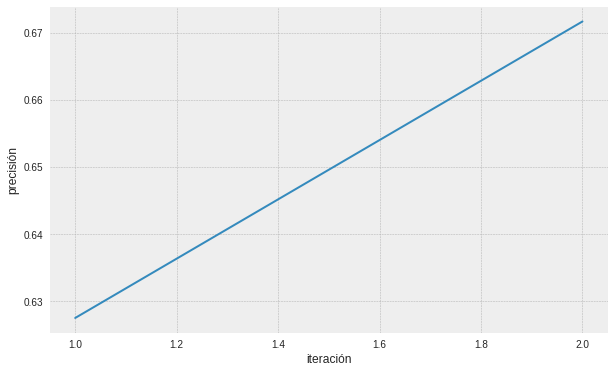

In [0]:
#@title Gráfico de precisión en cada valor de T
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
rend_data = pd.DataFrame(rend)
plt.plot(rend_data.loc[:,"iteración"],rend_data.loc[:,"precisión"])
plt.xlabel('iteración')
plt.ylabel('precisión')
img_name = 'adabnn-precision_' + adabnn_perf.iloc[0,0] + '_' + experimento + '.png'
plt.savefig(img_name, bbox_inches='tight')
files.download(img_name)

Populating the interactive namespace from numpy and matplotlib


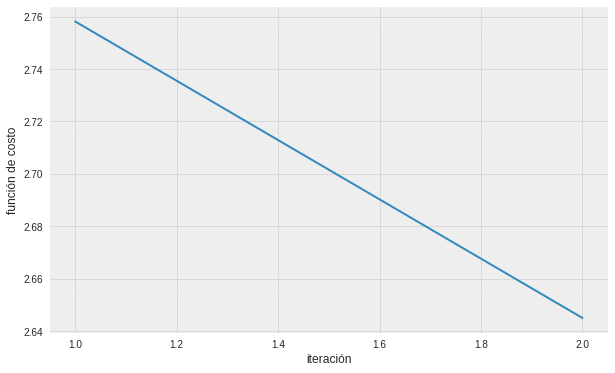

In [0]:
#@title Gráfico de función de costo en cada valor de T
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
rend_data = pd.DataFrame(rend)
plt.plot(rend_data.loc[:,"iteración"],rend_data.loc[:,"función de costo"])
plt.xlabel('iteración')
plt.ylabel('función de costo')
img_name = 'adabnn-costo_' + adabnn_perf.iloc[0,0] + '_' + experimento + '.png'
plt.savefig(img_name, bbox_inches='tight')
files.download(img_name)

Populating the interactive namespace from numpy and matplotlib


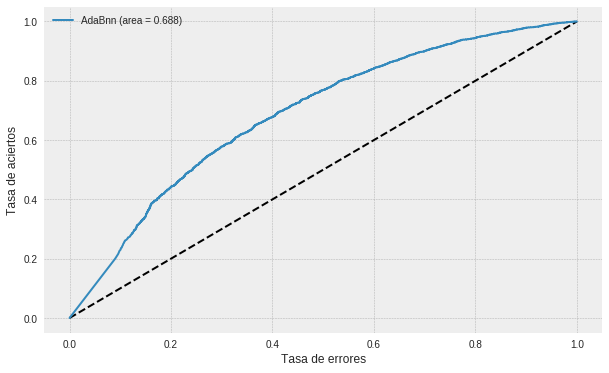

In [0]:
#@title Curva ROC de la clasificación 
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
y_pred_keras = model.predict(x_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='AdaBnn (area = {:.3f})'.format(auc_keras))
plt.xlabel('Tasa de errores')
plt.ylabel('Tasa de aciertos')
plt.legend(loc='best')
img_name = 'adabnn-roc_' + adabnn_perf.iloc[0,0] + '_' + experimento + '.png'
plt.savefig(img_name, bbox_inches='tight')
files.download(img_name)

##### Deers and Horse


In [0]:
#@title Preprocesamiento
x_train, y_train, x_test, y_test = prep_cifar_binary(4,7,cifar_x_train,cifar_y_train,cifar_x_test,cifar_y_test)
print('última ejecución: ', str(datetime.now()))

/usr/local/lib/python3.6/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


última ejecución:  2018-05-21 00:58:34.252186


In [0]:
#@title Selección de muestra mediante 'held out data'
from sklearn.model_selection import train_test_split
x_all = np.append(x_train,x_test,axis=0)
y_all = np.append(y_train,y_test,axis=0)
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.7, random_state=42)
print('última ejecución: ', str(datetime.now()))

última ejecución:  2018-05-21 00:58:35.016951


In [0]:
#@title Entrenamiento de AdaBnn
t1 = time.time()
model, rend = AdaBnn(x_train,y_train,conf,verbose=0)
t2 = time.time()
t_training = t2-t1
print('última ejecución: ', str(datetime.now()))

última ejecución:  2018-05-21 01:07:24.285135


In [0]:
#@title Evaluación de AdaBnn
t3 = time.time()
training_results = model.evaluate(x_test,y_test,verbose=0)
t4 = time.time()
t_inference = t4 - t3
print('última ejecución: ', str(datetime.now()))

última ejecución:  2018-05-21 01:07:43.491595


In [0]:
#@title Rendimiento de AdaBnn
min_v, max_v = conf_interval(len(y_test),training_results[1],0.95)
int_conv = "%.3f"%min(training_results[1] - min_v,max_v - training_results[1])
adabnn_perf = pd.DataFrame({
    'par':'deer-horse',
    't. entrenamiento': "%.0f"%t_training,
    't. inferencia': "%.0f"%t_inference,
    '# parámetros': model.count_params(),
    'precisión': "%.3f"%training_results[1],
    'intervalo de confianza (95%)': int_conv
}, index=[0])
adabnn_perf = adabnn_perf.reindex(columns=['par','t. entrenamiento','t. inferencia','# parámetros','precisión','intervalo de confianza (95%)'])
adabnn_perf

,par,t. entrenamiento,t. inferencia,# parámetros,precisión,intervalo de confianza (95%)
0,deer-horse,411,3,3721050,0.508,0.011


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['beta', 'concatenate', 'random', 'datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


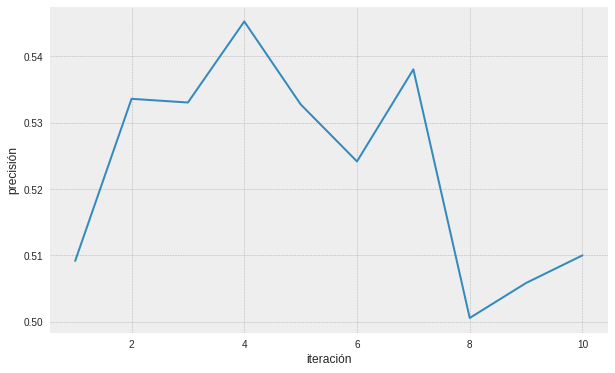

In [0]:
#@title Gráfico de precisión en cada valor de T
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
rend_data = pd.DataFrame(rend)
plt.plot(rend_data.loc[:,"iteración"],rend_data.loc[:,"precisión"])
plt.xlabel('iteración')
plt.ylabel('precisión')
img_name = 'adabnn-precision_' + adabnn_perf.iloc[0,0] + '_' + experimento + '.png'
plt.savefig(img_name, bbox_inches='tight')
files.download(img_name)

Populating the interactive namespace from numpy and matplotlib


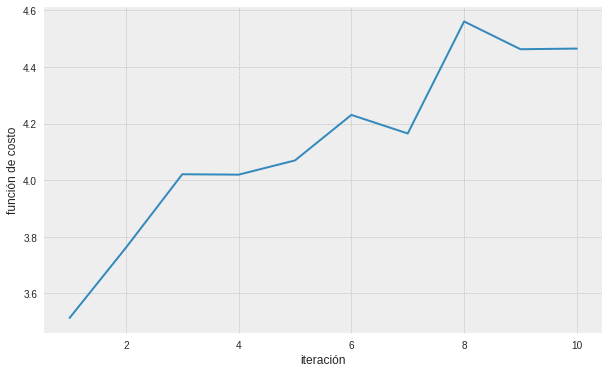

In [0]:
#@title Gráfico de función de costo en cada valor de T
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
rend_data = pd.DataFrame(rend)
plt.plot(rend_data.loc[:,"iteración"],rend_data.loc[:,"función de costo"])
plt.xlabel('iteración')
plt.ylabel('función de costo')
img_name = 'adabnn-costo_' + adabnn_perf.iloc[0,0] + '_' + experimento + '.png'
plt.savefig(img_name, bbox_inches='tight')
files.download(img_name)

Populating the interactive namespace from numpy and matplotlib


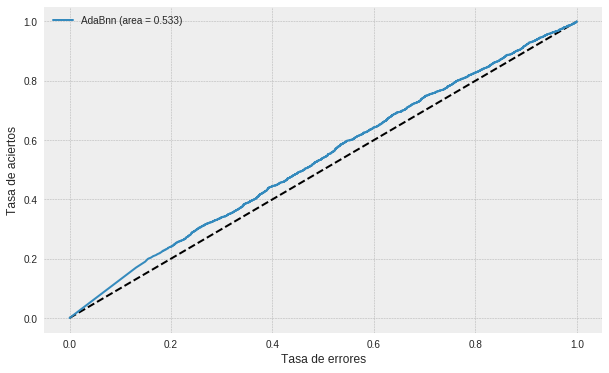

In [0]:
#@title Curva ROC de la clasificación 
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
y_pred_keras = model.predict(x_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='AdaBnn (area = {:.3f})'.format(auc_keras))
plt.xlabel('Tasa de errores')
plt.ylabel('Tasa de aciertos')
plt.legend(loc='best')
img_name = 'adabnn-roc_' + adabnn_perf.iloc[0,0] + '_' + experimento + '.png'
plt.savefig(img_name, bbox_inches='tight')
files.download(img_name)

##### Automobile and Truck

In [0]:
#@title Preprocesamiento
x_train, y_train, x_test, y_test = prep_cifar_binary(1,9,cifar_x_train,cifar_y_train,cifar_x_test,cifar_y_test)
print('última ejecución: ', str(datetime.now()))

/usr/local/lib/python3.6/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


AttributeError: ignored

In [0]:
#@title Selección de muestra mediante 'held out data'
from sklearn.model_selection import train_test_split
x_all = np.append(x_train,x_test,axis=0)
y_all = np.append(y_train,y_test,axis=0)
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.7, random_state=42)
print('última ejecución: ', str(datetime.now()))

última ejecución:  2018-05-21 01:19:20.902780


In [0]:
#@title Entrenamiento de AdaBnn
t1 = time.time()
model, rend = AdaBnn(x_train,y_train,conf,verbose=0)
t2 = time.time()
t_training = t2-t1
print('última ejecución: ', str(datetime.now()))

última ejecución:  2018-05-21 01:20:32.799291


In [0]:
#@title Evaluación de AdaBnn
t3 = time.time()
training_results = model.evaluate(x_test,y_test,verbose=0)
t4 = time.time()
t_inference = t4 - t3
print('última ejecución: ', str(datetime.now()))

última ejecución:  2018-05-21 01:20:34.649968


In [0]:
#@title Rendimiento de AdaBnn
min_v, max_v = conf_interval(len(y_test),training_results[1],0.95)
int_conv = "%.3f"%min(training_results[1] - min_v,max_v - training_results[1])
adabnn_perf = pd.DataFrame({
    'par':'automobile-truck',
    't. entrenamiento': "%.0f"%t_training,
    't. inferencia': "%.0f"%t_inference,
    '# parámetros': model.count_params(),
    'precisión': "%.3f"%training_results[1],
    'intervalo de confianza (95%)': int_conv
}, index=[0])
adabnn_perf = adabnn_perf.reindex(columns=['par','t. entrenamiento','t. inferencia','# parámetros','precisión','intervalo de confianza (95%)'])
adabnn_perf

,par,t. entrenamiento,t. inferencia,# parámetros,precisión,intervalo de confianza (95%)
0,automobile-truck,68,1,489150,0.460,0.011


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['beta', 'concatenate', 'random', 'datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


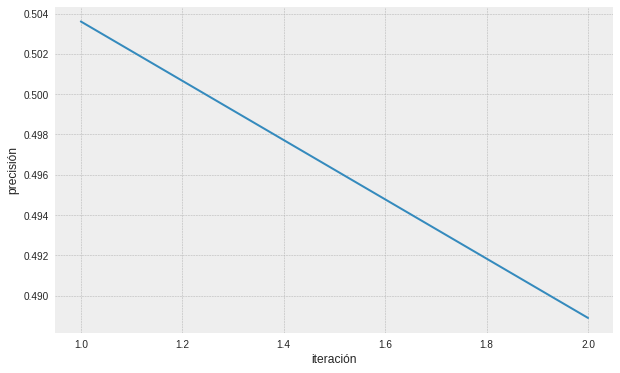

In [0]:
#@title Gráfico de precisión en cada valor de T
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
rend_data = pd.DataFrame(rend)
plt.plot(rend_data.loc[:,"iteración"],rend_data.loc[:,"precisión"])
plt.xlabel('iteración')
plt.ylabel('precisión')
img_name = 'adabnn-precision_' + adabnn_perf.iloc[0,0] + '_' + experimento + '.png'
plt.savefig(img_name, bbox_inches='tight')
files.download(img_name)

Populating the interactive namespace from numpy and matplotlib


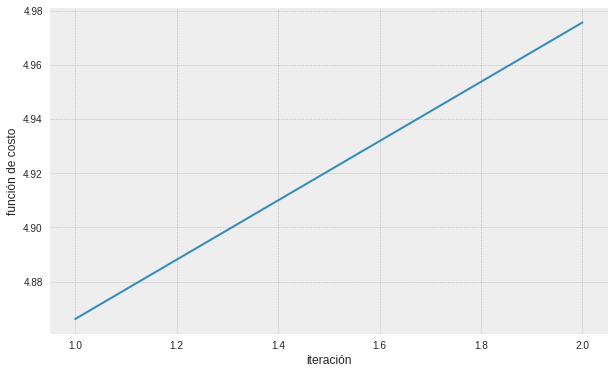

In [0]:
#@title Gráfico de función de costo en cada valor de T
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
rend_data = pd.DataFrame(rend)
plt.plot(rend_data.loc[:,"iteración"],rend_data.loc[:,"función de costo"])
plt.xlabel('iteración')
plt.ylabel('función de costo')
img_name = 'adabnn-costo_' + adabnn_perf.iloc[0,0] + '_' + experimento + '.png'
plt.savefig(img_name, bbox_inches='tight')
files.download(img_name)

Populating the interactive namespace from numpy and matplotlib


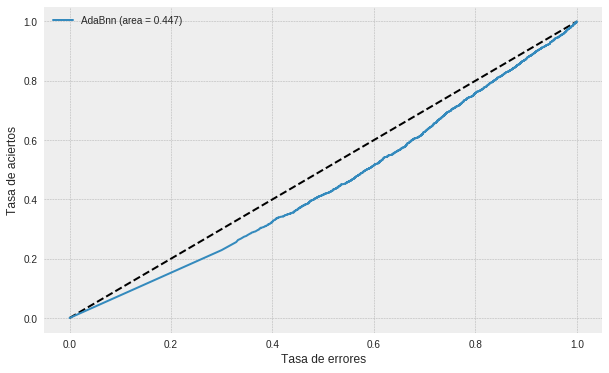

In [0]:
#@title Curva ROC de la clasificación 
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
y_pred_keras = model.predict(x_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='AdaBnn (area = {:.3f})'.format(auc_keras))
plt.xlabel('Tasa de errores')
plt.ylabel('Tasa de aciertos')
plt.legend(loc='best')
img_name = 'adabnn-roc_' + adabnn_perf.iloc[0,0] + '_' + experimento + '.png'
plt.savefig(img_name, bbox_inches='tight')
files.download(img_name)

##### Cat and Dog

In [0]:
#@title Preprocesamiento
x_train, y_train, x_test, y_test = prep_cifar_binary(3,5,cifar_x_train,cifar_y_train,cifar_x_test,cifar_y_test)
print('última ejecución: ', str(datetime.now()))

/usr/local/lib/python3.6/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


última ejecución:  2018-05-21 01:22:06.865589


In [0]:
#@title Selección de muestra mediante 'held out data'
from sklearn.model_selection import train_test_split
x_all = np.append(x_train,x_test,axis=0)
y_all = np.append(y_train,y_test,axis=0)
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.7, random_state=42)
print('última ejecución: ', str(datetime.now()))

última ejecución:  2018-05-21 01:22:07.474199


In [0]:
#@title Entrenamiento de AdaBnn
t1 = time.time()
model, rend = AdaBnn(x_train,y_train,conf,verbose=0)
t2 = time.time()
t_training = t2-t1
print('última ejecución: ', str(datetime.now()))

última ejecución:  2018-05-21 01:23:16.311079


In [0]:
#@title Evaluación de AdaBnn
t3 = time.time()
training_results = model.evaluate(x_test,y_test,verbose=0)
t4 = time.time()
t_inference = t4 - t3
print('última ejecución: ', str(datetime.now()))

última ejecución:  2018-05-21 01:23:17.983905


In [0]:
#@title Rendimiento de AdaBnn
min_v, max_v = conf_interval(len(y_test),training_results[1],0.95)
int_conv = "%.3f"%min(training_results[1] - min_v,max_v - training_results[1])
adabnn_perf = pd.DataFrame({
    'par':'cat-dog',
    't. entrenamiento': "%.0f"%t_training,
    't. inferencia': "%.0f"%t_inference,
    '# parámetros': model.count_params(),
    'precisión': "%.3f"%training_results[1],
    'intervalo de confianza (95%)': int_conv
}, index=[0])
adabnn_perf = adabnn_perf.reindex(columns=['par','t. entrenamiento','t. inferencia','# parámetros','precisión','intervalo de confianza (95%)'])
adabnn_perf

,par,t. entrenamiento,t. inferencia,# parámetros,precisión,intervalo de confianza (95%)
0,cat-dog,68,1,444150,0.495,0.011


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['beta', 'concatenate', 'random', 'datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


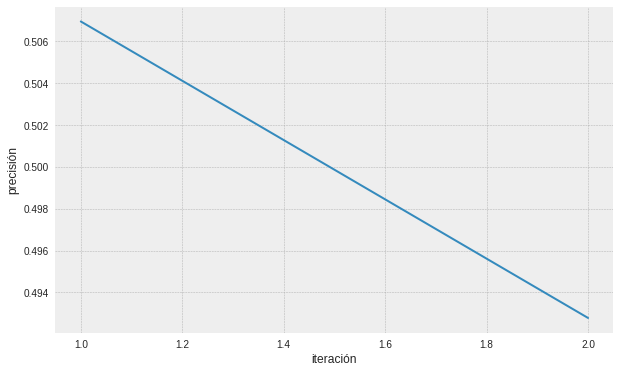

In [0]:
#@title Gráfico de precisión en cada valor de T
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
rend_data = pd.DataFrame(rend)
plt.plot(rend_data.loc[:,"iteración"],rend_data.loc[:,"precisión"])
plt.xlabel('iteración')
plt.ylabel('precisión')
img_name = 'adabnn-precision_' + adabnn_perf.iloc[0,0] + '_' + experimento + '.png'
plt.savefig(img_name, bbox_inches='tight')
files.download(img_name)

Populating the interactive namespace from numpy and matplotlib


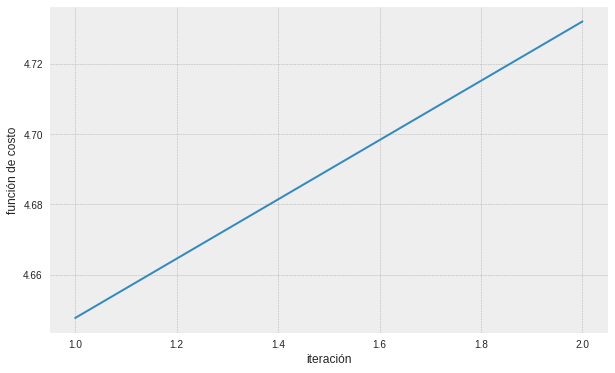

In [0]:
#@title Gráfico de función de costo en cada valor de T
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
rend_data = pd.DataFrame(rend)
plt.plot(rend_data.loc[:,"iteración"],rend_data.loc[:,"función de costo"])
plt.xlabel('iteración')
plt.ylabel('función de costo')
img_name = 'adabnn-costo_' + adabnn_perf.iloc[0,0] + '_' + experimento + '.png'
plt.savefig(img_name, bbox_inches='tight')
files.download(img_name)

Populating the interactive namespace from numpy and matplotlib


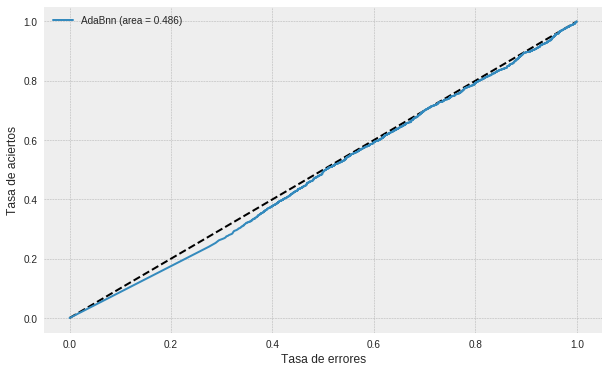

In [0]:
#@title Curva ROC de la clasificación 
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
y_pred_keras = model.predict(x_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='AdaBnn (area = {:.3f})'.format(auc_keras))
plt.xlabel('Tasa de errores')
plt.ylabel('Tasa de aciertos')
plt.legend(loc='best')
img_name = 'adabnn-roc_' + adabnn_perf.iloc[0,0] + '_' + experimento + '.png'
plt.savefig(img_name, bbox_inches='tight')
files.download(img_name)

##### Dog and Horse

In [0]:
#@title Preprocesamiento
x_train, y_train, x_test, y_test = prep_cifar_binary(5,7,cifar_x_train,cifar_y_train,cifar_x_test,cifar_y_test)
print('última ejecución: ', str(datetime.now()))

/usr/local/lib/python3.6/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


última ejecución:  2018-05-21 01:43:05.116206


In [0]:
#@title Selección de muestra mediante 'held out data'
from sklearn.model_selection import train_test_split
x_all = np.append(x_train,x_test,axis=0)
y_all = np.append(y_train,y_test,axis=0)
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.7, random_state=42)
print('última ejecución: ', str(datetime.now()))

última ejecución:  2018-05-21 01:43:05.823579


In [0]:
#@title Entrenamiento de AdaBnn
t1 = time.time()
model, rend = AdaBnn(x_train,y_train,conf,verbose=0)
t2 = time.time()
t_training = t2-t1
print('última ejecución: ', str(datetime.now()))

última ejecución:  2018-05-21 01:44:38.022296


In [0]:
#@title Evaluación de AdaBnn
t3 = time.time()
training_results = model.evaluate(x_test,y_test,verbose=0)
t4 = time.time()
t_inference = t4 - t3
print('última ejecución: ', str(datetime.now()))

última ejecución:  2018-05-21 01:44:39.583442


In [0]:
#@title Rendimiento de AdaBnn
min_v, max_v = conf_interval(len(y_test),training_results[1],0.95)
int_conv = "%.3f"%min(training_results[1] - min_v,max_v - training_results[1])
adabnn_perf = pd.DataFrame({
    'par':'dog-horse',
    't. entrenamiento': "%.0f"%t_training,
    't. inferencia': "%.0f"%t_inference,
    '# parámetros': model.count_params(),
    'precisión': "%.3f"%training_results[1],
    'intervalo de confianza (95%)': int_conv
}, index=[0])
adabnn_perf = adabnn_perf.reindex(columns=['par','t. entrenamiento','t. inferencia','# parámetros','precisión','intervalo de confianza (95%)'])
adabnn_perf

,par,t. entrenamiento,t. inferencia,# parámetros,precisión,intervalo de confianza (95%)
0,dog-horse,91,1,376650,0.512,0.011


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['beta', 'concatenate', 'random', 'datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


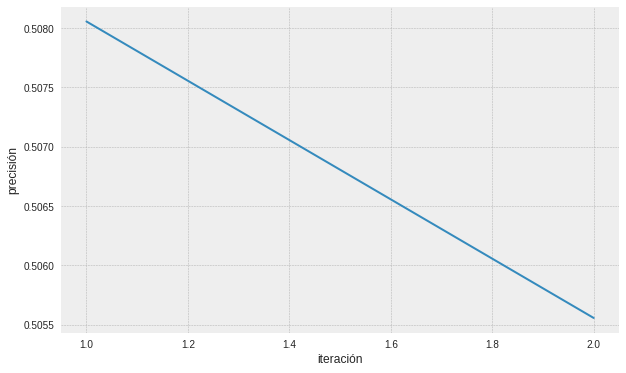

In [0]:
#@title Gráfico de precisión en cada valor de T
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
rend_data = pd.DataFrame(rend)
plt.plot(rend_data.loc[:,"iteración"],rend_data.loc[:,"precisión"])
plt.xlabel('iteración')
plt.ylabel('precisión')
img_name = 'adabnn-precision_' + adabnn_perf.iloc[0,0] + '_' + experimento + '.png'
plt.savefig(img_name, bbox_inches='tight')
files.download(img_name)

Populating the interactive namespace from numpy and matplotlib


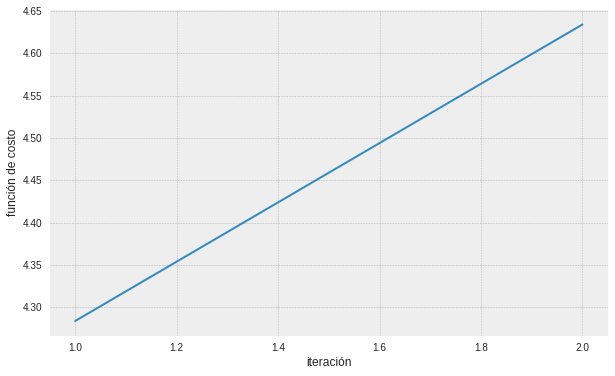

In [0]:
#@title Gráfico de función de costo en cada valor de T
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
rend_data = pd.DataFrame(rend)
plt.plot(rend_data.loc[:,"iteración"],rend_data.loc[:,"función de costo"])
plt.xlabel('iteración')
plt.ylabel('función de costo')
img_name = 'adabnn-costo_' + adabnn_perf.iloc[0,0] + '_' + experimento + '.png'
plt.savefig(img_name, bbox_inches='tight')
files.download(img_name)

Populating the interactive namespace from numpy and matplotlib


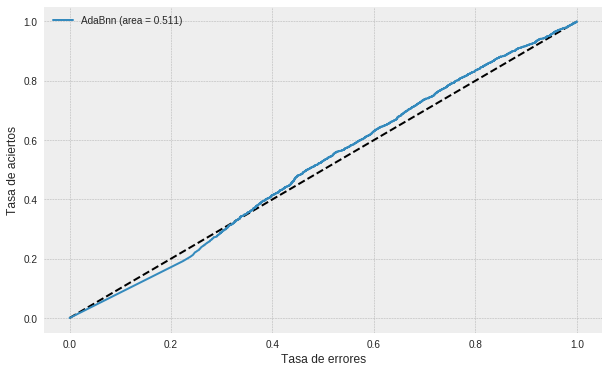

In [0]:
#@title Curva ROC de la clasificación 
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
y_pred_keras = model.predict(x_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='AdaBnn (area = {:.3f})'.format(auc_keras))
plt.xlabel('Tasa de errores')
plt.ylabel('Tasa de aciertos')
plt.legend(loc='best')
img_name = 'adabnn-roc_' + adabnn_perf.iloc[0,0] + '_' + experimento + '.png'
plt.savefig(img_name, bbox_inches='tight')
files.download(img_name)

#### Clasificación multiclase

In [0]:
#@title Configuración de AdaBnn
epochs = 20 #@param {type:"integer"}
B = 150 #@param {type:"integer"}
T = 2 #@param {type:"integer"}

conf = dict({
    'network': {
        'activation': 'relu',
        'output_activation': 'softmax',# softmax for multiple clases
        'optimizer': keras.optimizers.RMSprop(lr=0.0001),#opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
        'loss': 'categorical_crossentropy' # F for adanet traditional
        },
    'training':{
        'batch_size': 100,
        'epochs': epochs,
        },
    'adabnn':{
        'B': B,#3,
        'T': T,#5
        'delta': 1.01,
        'seed': 42
        }
    })
adabnn_conf = pd.DataFrame({
    'función de costo': conf['network']['loss'],
    'función de optimización': str(conf['network']['optimizer'])[18:str(conf['network']['optimizer']).find(' ')],
    'observaciones por lote': conf['training']['batch_size'],
    'número de épocas': conf['training']['epochs'],
    'B': conf['adabnn']['B'],
    'T': conf['adabnn']['T']
}, index=[0])
adabnn_conf = adabnn_conf.reindex(columns=['B','T','función de costo','función de optimización','observaciones por lote','número de épocas'])
experimento = '_'.join([str(j) for j in adabnn_conf.iloc[0,:]])
adabnn_conf

,B,T,función de costo,función de optimización,observaciones por lote,número de épocas
0,150,2,categorical_crossentropy,RMSprop,100,20


In [0]:
#@title Preprocesamiento
x_train, y_train, x_test, y_test = prep_cifar_multi(cifar_x_train,cifar_y_train,cifar_x_test,cifar_y_test)
print('última ejecución: ', str(datetime.now()))

/usr/local/lib/python3.6/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


última ejecución:  2018-05-21 02:25:48.703237


In [0]:
#@title Selección de muestra mediante 'held out data'
from sklearn.model_selection import train_test_split
x_all = np.append(x_train,x_test,axis=0)
y_all = np.append(y_train,y_test,axis=0)
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.7, random_state=42)
print('última ejecución: ', str(datetime.now()))

última ejecución:  2018-05-21 02:25:49.695799


In [0]:
#@title Entrenamiento de AdaBnn
t1 = time.time()
model, rend = AdaBnn(x_train,y_train,conf,verbose=0,classes=10)
t2 = time.time()
t_training = t2-t1
print('última ejecución: ', str(datetime.now()))

última ejecución:  2018-05-21 02:29:21.146061


In [0]:
#@title Evaluación de AdaBnn
t3 = time.time()
training_results = model.evaluate(x_test,y_test,verbose=0)
t4 = time.time()
t_inference = t4 - t3
print('última ejecución: ', str(datetime.now()))

última ejecución:  2018-05-21 02:29:27.847309


In [0]:
#@title Rendimiento de AdaBnn
min_v, max_v = conf_interval(len(y_test),training_results[1],0.95)
int_conv = "%.3f"%min(training_results[1] - min_v,max_v - training_results[1])
adabnn_perf = pd.DataFrame({
    'par':'todos',
    't. entrenamiento': "%.0f"%t_training,
    't. inferencia': "%.0f"%t_inference,
    '# parámetros': model.count_params(),
    'precisión': "%.3f"%training_results[1],
    'intervalo de confianza (95%)': int_conv
}, index=[0])
adabnn_perf = adabnn_perf.reindex(columns=['par','t. entrenamiento','t. inferencia','# parámetros','precisión','intervalo de confianza (95%)'])
adabnn_perf

,par,t. entrenamiento,t. inferencia,# parámetros,precisión,intervalo de confianza (95%)
0,todos,211,6,560700,0.148,0.003


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['beta', 'concatenate', 'random', 'datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


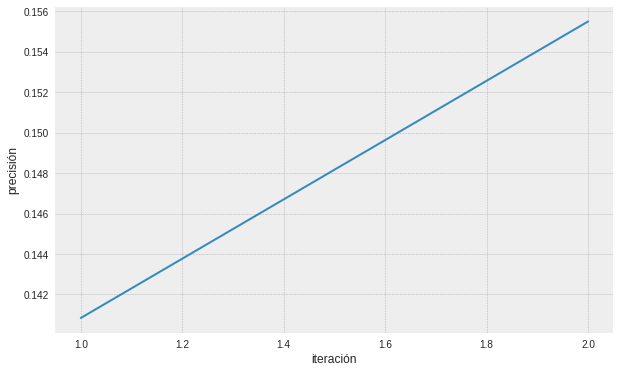

In [0]:
#@title Gráfico de precisión en cada valor de T
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
rend_data = pd.DataFrame(rend)
plt.plot(rend_data.loc[:,"iteración"],rend_data.loc[:,"precisión"])
plt.xlabel('iteración')
plt.ylabel('precisión')
img_name = 'adabnn-precision_' + adabnn_perf.iloc[0,0] + '_' + experimento + '.png'
plt.savefig(img_name, bbox_inches='tight')
files.download(img_name)

Populating the interactive namespace from numpy and matplotlib


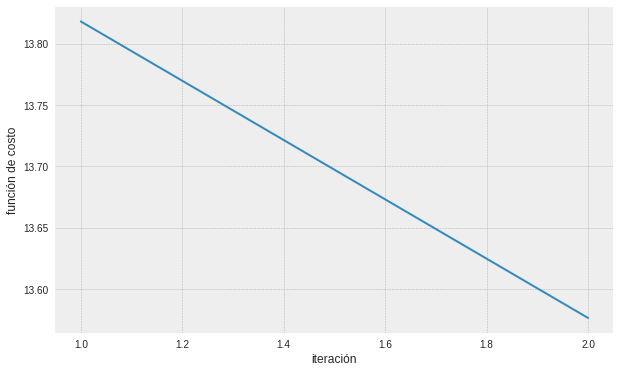

In [0]:
#@title Gráfico de función de costo en cada valor de T
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
rend_data = pd.DataFrame(rend)
plt.plot(rend_data.loc[:,"iteración"],rend_data.loc[:,"función de costo"])
plt.xlabel('iteración')
plt.ylabel('función de costo')
img_name = 'adabnn-costo_' + adabnn_perf.iloc[0,0] + '_' + experimento + '.png'
plt.savefig(img_name, bbox_inches='tight')
files.download(img_name)

### Experimentos con MNIST

In [0]:
#@title Configuración de AdaBnn
epochs = 20 #@param {type:"integer"}
B = 150 #@param {type:"integer"}
T = 5 #@param {type:"integer"}
conf = dict({
    'network': {
        'activation': 'relu',
        'output_activation': 'softmax',# softmax for multiple clases
        'optimizer': keras.optimizers.RMSprop(lr=0.0001),#opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
        'loss': 'categorical_crossentropy' # F for adanet traditional
        },
    'training':{
        'batch_size': 100,
        'epochs': epochs,
        },
    'adabnn':{
        'B': B,#3,
        'T': T,#5
        'delta': 1.01,
        'seed': 42
        }
    })
adabnn_conf = pd.DataFrame({
    'función de costo': conf['network']['loss'],
    'función de optimización': str(conf['network']['optimizer'])[18:str(conf['network']['optimizer']).find(' ')],
    'observaciones por lote': conf['training']['batch_size'],
    'número de épocas': conf['training']['epochs'],
    'B': conf['adabnn']['B'],
    'T': conf['adabnn']['T']
}, index=[0])
adabnn_conf = adabnn_conf.reindex(columns=['B','T','función de costo','función de optimización','observaciones por lote','número de épocas'])
experimento = '_'.join([str(j) for j in adabnn_conf.iloc[0,:]])
adabnn_conf

,B,T,función de costo,función de optimización,observaciones por lote,número de épocas
0,150,5,categorical_crossentropy,RMSprop,100,20


In [0]:
#@title Preprocesamiento 
x_train, y_train, x_test, y_test = prep_mnist_multi(mnist_x_train,mnist_y_train,mnist_x_test,mnist_y_test)
print('última ejecución: ', str(datetime.now()))

última ejecución:  2018-05-21 06:25:17.037492


In [0]:
#@title Selección de muestra mediante 'held out data'
from sklearn.model_selection import train_test_split
x_all = np.append(x_train,x_test,axis=0)
y_all = np.append(y_train,y_test,axis=0)
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.7, random_state=42)
print('última ejecución: ', str(datetime.now()))

última ejecución:  2018-05-21 06:25:18.021777


In [0]:
#@title Entrenamiento de AdaBnn
t1 = time.time()
model, rend = AdaBnn(x_train,y_train,conf,verbose=0,classes=10)
t2 = time.time()
t_training = t2-t1
print('última ejecución: ', str(datetime.now()))

última ejecución:  2018-05-21 08:03:34.742002


In [0]:
#@title Evaluación de AdaBnn
t3 = time.time()
training_results = model.evaluate(x_test,y_test,verbose=0)
t4 = time.time()
t_inference = t4 - t3
print('última ejecución: ', str(datetime.now()))

última ejecución:  2018-05-21 08:04:54.289649


In [0]:
#@title Rendimiento de AdaBnn
min_v, max_v = conf_interval(len(y_test),training_results[1],0.95)
int_conv = "%.3f"%min(training_results[1] - min_v,max_v - training_results[1])
adabnn_perf = pd.DataFrame({
    'par':'mnist',
    't. entrenamiento': "%.0f"%t_training,
    't. inferencia': "%.0f"%t_inference,
    '# parámetros': model.count_params(),
    'precisión': "%.3f"%training_results[1],
    'intervalo de confianza (95%)': int_conv
}, index=[0])
adabnn_perf = adabnn_perf.reindex(columns=['par','t. entrenamiento','t. inferencia','# parámetros','precisión','intervalo de confianza (95%)'])
adabnn_perf

,par,t. entrenamiento,t. inferencia,# parámetros,precisión,intervalo de confianza (95%)
0,mnist,1981,10,1704600,0.107,0.003


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['beta', 'concatenate', 'datetime', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


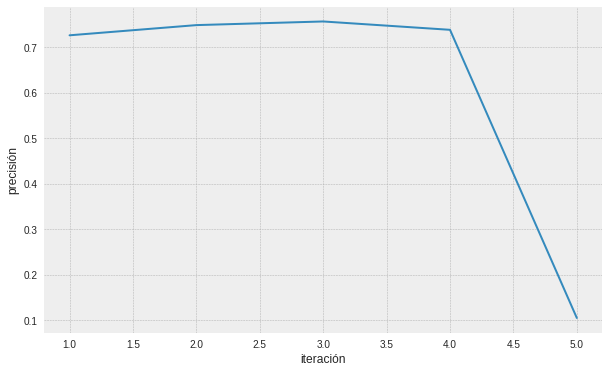

In [0]:
#@title Gráfico de precisión en cada valor de T
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
rend_data = pd.DataFrame(rend)
plt.plot(rend_data.loc[:,"iteración"],rend_data.loc[:,"precisión"])
plt.xlabel('iteración')
plt.ylabel('precisión')
img_name = 'adabnn-precision_' + adabnn_perf.iloc[0,0] + '_' + experimento + '.png'
plt.savefig(img_name, bbox_inches='tight')
files.download(img_name)

Populating the interactive namespace from numpy and matplotlib


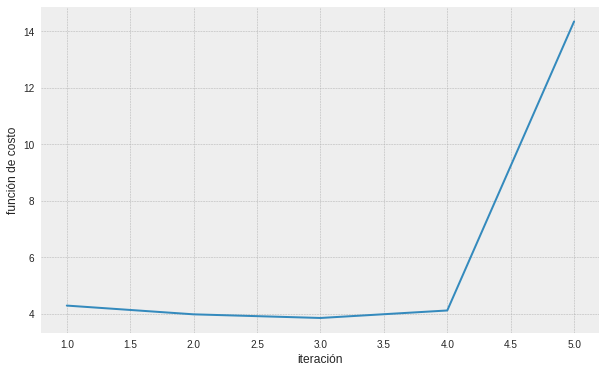

In [0]:
#@title Gráfico de función de costo en cada valor de T
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
rend_data = pd.DataFrame(rend)
plt.plot(rend_data.loc[:,"iteración"],rend_data.loc[:,"función de costo"])
plt.xlabel('iteración')
plt.ylabel('función de costo')
img_name = 'adabnn-costo_' + adabnn_perf.iloc[0,0] + '_' + experimento + '.png'
plt.savefig(img_name, bbox_inches='tight')
files.download(img_name)

## Experimentos con AdaNet

### Experimentos con CIFAR-10

#### Clasificación binaria

In [0]:
#@title Configuración de AdaNet
epochs = 20 #@param {type:"integer"}
B = 150 #@param {type:"integer"}
T = 5 #@param {type:"integer"}
conf = dict({
    'network': {
        'activation': 'relu',
        'output_activation': 'sigmoid',# softmax for multiple clases
        'optimizer': keras.optimizers.adam(lr=0.0001),#Adam
        'loss': 'binary_crossentropy' # F for adanet traditional
        },
    'training':{
        'batch_size': 100,
        'epochs': epochs#2,10
        },
    'adanet':{
        'B': B,
        'T': T,#5,15
        'delta': 1.01
        }
    })
adanet_conf = pd.DataFrame({
    'f. costo': conf['network']['loss'],
    'f. optimización': str(conf['network']['optimizer'])[18:str(conf['network']['optimizer']).find(' ')],
    'tamaño de lote': conf['training']['batch_size'],
    '# épocas': conf['training']['epochs'],
    'B': conf['adanet']['B'],
    'T': conf['adanet']['T']
}, index=[0])
adanet_conf = adanet_conf.reindex(columns=['B','T','f. costo','f. optimización','tamaño de lote','# épocas'])
experimento = '_'.join([str(j) for j in adanet_conf.iloc[0,:]])
adanet_conf

,B,T,f. costo,f. optimización,tamaño de lote,# épocas
0,150,2,binary_crossentropy,Adam,100,25


##### Deers and Trucks

In [0]:
#@title Preprocesamiento
x_train, y_train, x_test, y_test = prep_cifar_binary(4,9,cifar_x_train,cifar_y_train,cifar_x_test,cifar_y_test)
print('última ejecución: ', str(datetime.now()))

/usr/local/lib/python3.6/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


última ejecución:  2018-05-21 08:48:40.246520


In [0]:
#@title Selección de muestra mediante 'held out data'
from sklearn.model_selection import train_test_split
x_all = np.append(x_train,x_test,axis=0)
y_all = np.append(y_train,y_test,axis=0)
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.7, random_state=42)
print('última ejecución: ', str(datetime.now()))

última ejecución:  2018-05-21 08:48:41.773458


In [0]:
#@title Entrenamiento de AdaNet
t1 = time.time()
model, rend = AdaNet(x_train,y_train,conf,verbose=0)
t2 = time.time()
t_training = t2-t1
print('última ejecución: ', str(datetime.now()))

última ejecución:  2018-05-21 08:51:41.095573


In [0]:
#@title Evaluación de AdaNet
t3 = time.time()
training_results = model.evaluate(x_test,y_test,verbose=0)
t4 = time.time()
t_inference = t4 - t3
print('última ejecución: ', str(datetime.now()))

última ejecución:  2018-05-21 08:51:43.744826


In [0]:
#@title Rendimiento de AdaNet
min_v, max_v = conf_interval(len(y_test),training_results[1],0.95)
int_conv = "%.3f"%min(training_results[1] - min_v,max_v - training_results[1])
adanet_perf = pd.DataFrame({
    'par':'deer-truck',
    't. entrenamiento': "%.0f"%t_training,
    't. inferencia': "%.0f"%t_inference,
    '# parámetros': model.count_params(),
    'precisión': "%.3f"%training_results[1],
    'intervalo de confianza (95%)': int_conv
}, index=[0])
adanet_perf = adanet_perf.reindex(columns=['par','t. entrenamiento','t. inferencia','# parámetros','precisión','intervalo de confianza (95%)'])
adanet_perf

,par,t. entrenamiento,t. inferencia,# parámetros,precisión,intervalo de confianza (95%)
0,deer-truck,178,2,556650,0.893,0.006


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['beta', 'datetime', 'concatenate', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


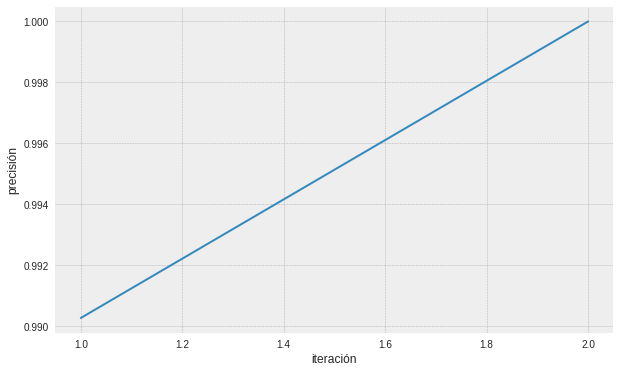

In [0]:
#@title Gráfico de precisión en cada valor de T
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
rend_data = pd.DataFrame(rend)
plt.plot(rend_data.loc[:,"iteración"],rend_data.loc[:,"precisión"])
plt.xlabel('iteración')
plt.ylabel('precisión')
img_name = 'adanet-precision_' + adanet_perf.iloc[0,0] + '_' + experimento + '.png'
plt.savefig(img_name, bbox_inches='tight')
files.download(img_name)

Populating the interactive namespace from numpy and matplotlib


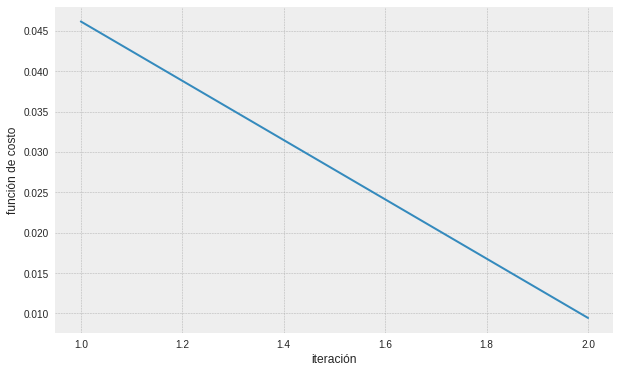

In [0]:
#@title Gráfico de función de costo en cada valor de T
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
rend_data = pd.DataFrame(rend)
plt.plot(rend_data.loc[:,"iteración"],rend_data.loc[:,"función de costo"])
plt.xlabel('iteración')
plt.ylabel('función de costo')
img_name = 'adanet-costo_' + adanet_perf.iloc[0,0] + '_' + experimento + '.png'
plt.savefig(img_name, bbox_inches='tight')
files.download(img_name)

Populating the interactive namespace from numpy and matplotlib


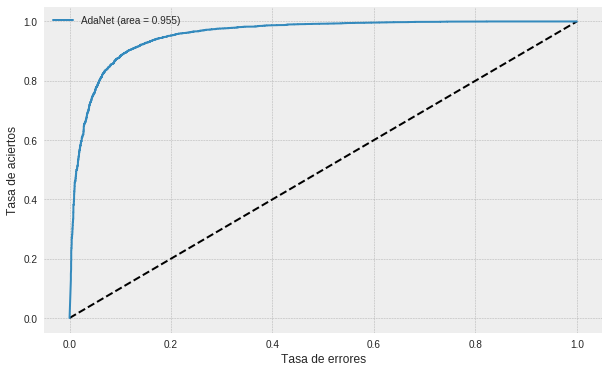

In [0]:
#@title Curva ROC de la clasificación 
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
y_pred_keras = model.predict(x_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='AdaNet (area = {:.3f})'.format(auc_keras))
plt.xlabel('Tasa de errores')
plt.ylabel('Tasa de aciertos')
plt.legend(loc='best')
img_name = 'adanet-roc_' + adanet_perf.iloc[0,0] + '_' + experimento + '.png'
plt.savefig(img_name, bbox_inches='tight')
files.download(img_name)

##### Deers and Horse


In [0]:
#@title Preprocesamiento
x_train, y_train, x_test, y_test = prep_cifar_binary(4,7,cifar_x_train,cifar_y_train,cifar_x_test,cifar_y_test)
print('última ejecución: ', str(datetime.now()))

/usr/local/lib/python3.6/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


última ejecución:  2018-05-21 09:00:04.173699


In [0]:
#@title Selección de muestra mediante 'held out data'
from sklearn.model_selection import train_test_split
x_all = np.append(x_train,x_test,axis=0)
y_all = np.append(y_train,y_test,axis=0)
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.7, random_state=42)
print('última ejecución: ', str(datetime.now()))

última ejecución:  2018-05-21 09:00:04.685420


In [0]:
#@title Entrenamiento de AdaNet
t1 = time.time()
model, rend = AdaNet(x_train,y_train,conf,verbose=0)
t2 = time.time()
t_training = t2-t1
print('última ejecución: ', str(datetime.now()))

última ejecución:  2018-05-21 09:10:43.172468


In [0]:
#@title Evaluación de AdaNet
t3 = time.time()
training_results = model.evaluate(x_test,y_test,verbose=0)
t4 = time.time()
t_inference = t4 - t3
print('última ejecución: ', str(datetime.now()))

última ejecución:  2018-05-21 09:10:46.886201


In [0]:
#@title Rendimiento de AdaNet
min_v, max_v = conf_interval(len(y_test),training_results[1],0.95)
int_conv = "%.3f"%min(training_results[1] - min_v,max_v - training_results[1])
adanet_perf = pd.DataFrame({
    'par':'deer-horse',
    't. entrenamiento': "%.0f"%t_training,
    't. inferencia': "%.0f"%t_inference,
    '# parámetros': model.count_params(),
    'precisión': "%.3f"%training_results[1],
    'intervalo de confianza (95%)': int_conv
}, index=[0])
adanet_perf = adanet_perf.reindex(columns=['par','t. entrenamiento','t. inferencia','# parámetros','precisión','intervalo de confianza (95%)'])
adanet_perf

,par,t. entrenamiento,t. inferencia,# parámetros,precisión,intervalo de confianza (95%)
0,deer-horse,638,3,1765800,0.750,0.009


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['beta', 'datetime', 'concatenate', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


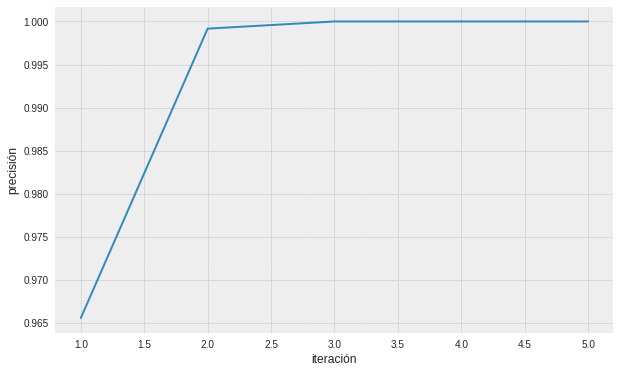

In [0]:
#@title Gráfico de precisión en cada valor de T
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
rend_data = pd.DataFrame(rend)
plt.plot(rend_data.loc[:,"iteración"],rend_data.loc[:,"precisión"])
plt.xlabel('iteración')
plt.ylabel('precisión')
img_name = 'adanet-precision_' + adanet_perf.iloc[0,0] + '_' + experimento + '.png'
plt.savefig(img_name, bbox_inches='tight')
files.download(img_name)

Populating the interactive namespace from numpy and matplotlib


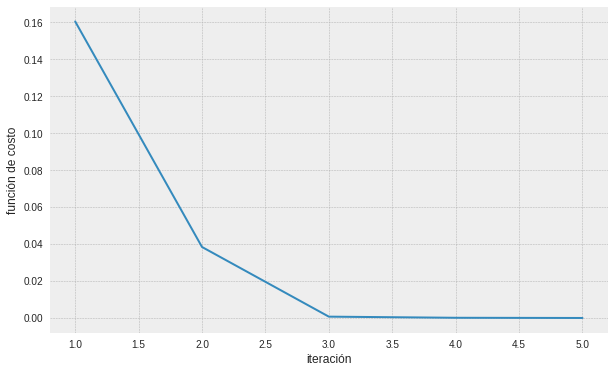

In [0]:
#@title Gráfico de función de costo en cada valor de T
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
rend_data = pd.DataFrame(rend)
plt.plot(rend_data.loc[:,"iteración"],rend_data.loc[:,"función de costo"])
plt.xlabel('iteración')
plt.ylabel('función de costo')
img_name = 'adanet-costo_' + adanet_perf.iloc[0,0] + '_' + experimento + '.png'
plt.savefig(img_name, bbox_inches='tight')
files.download(img_name)

Populating the interactive namespace from numpy and matplotlib


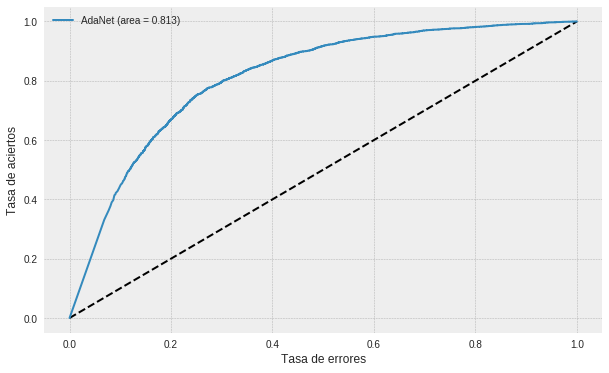

In [0]:
#@title Curva ROC de la clasificación 
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
y_pred_keras = model.predict(x_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='AdaNet (area = {:.3f})'.format(auc_keras))
plt.xlabel('Tasa de errores')
plt.ylabel('Tasa de aciertos')
plt.legend(loc='best')
img_name = 'adanet-roc_' + adanet_perf.iloc[0,0] + '_' + experimento + '.png'
plt.savefig(img_name, bbox_inches='tight')
files.download(img_name)

##### Automobile and Truck

In [0]:
#@title Preprocesamiento
x_train, y_train, x_test, y_test = prep_cifar_binary(1,9,cifar_x_train,cifar_y_train,cifar_x_test,cifar_y_test)
print('última ejecución: ', str(datetime.now()))

/usr/local/lib/python3.6/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


última ejecución:  2018-05-21 18:00:26.072815


In [0]:
#@title Selección de muestra mediante 'held out data'
from sklearn.model_selection import train_test_split
x_all = np.append(x_train,x_test,axis=0)
y_all = np.append(y_train,y_test,axis=0)
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.7, random_state=42)
print('última ejecución: ', str(datetime.now()))

última ejecución:  2018-05-21 18:00:26.821080


In [0]:
#@title Entrenamiento de AdaNet
t1 = time.time()
model, rend = AdaNet(x_train,y_train,conf,verbose=0)
t2 = time.time()
t_training = t2-t1
print('última ejecución: ', str(datetime.now()))

última ejecución:  2018-05-21 18:01:07.099966


In [0]:
#@title Evaluación de AdaNet
t3 = time.time()
training_results = model.evaluate(x_test,y_test,verbose=0)
t4 = time.time()
t_inference = t4 - t3
print('última ejecución: ', str(datetime.now()))

última ejecución:  2018-05-21 18:01:09.231040


In [0]:
#@title Rendimiento de AdaNet
min_v, max_v = conf_interval(len(y_test),training_results[1],0.95)
int_conv = "%.3f"%min(training_results[1] - min_v,max_v - training_results[1])
adanet_perf = pd.DataFrame({
    'par':'automobile-truck',
    't. entrenamiento': "%.0f"%t_training,
    't. inferencia': "%.0f"%t_inference,
    '# parámetros': model.count_params(),
    'precisión': "%.3f"%training_results[1],
    'intervalo de confianza (95%)': int_conv
}, index=[0])
adanet_perf = adanet_perf.reindex(columns=['par','t. entrenamiento','t. inferencia','# parámetros','precisión','intervalo de confianza (95%)'])
adanet_perf

,par,t. entrenamiento,t. inferencia,# parámetros,precisión,intervalo de confianza (95%)
0,automobile-truck,39,1,556650,0.690,0.010


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['datetime', 'random', 'beta', 'concatenate']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


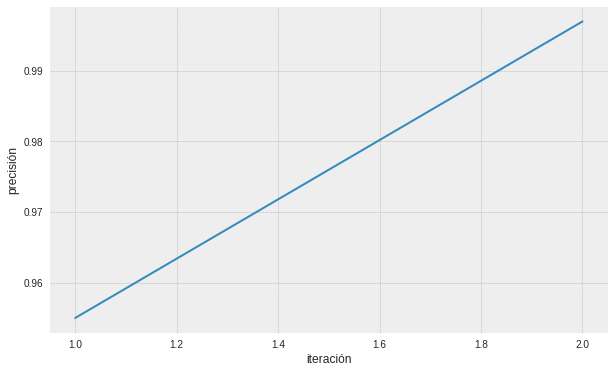

In [0]:
#@title Gráfico de precisión en cada valor de T
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
rend_data = pd.DataFrame(rend)
plt.plot(rend_data.loc[:,"iteración"],rend_data.loc[:,"precisión"])
plt.xlabel('iteración')
plt.ylabel('precisión')
img_name = 'adanet-precision_' + adanet_perf.iloc[0,0] + '_' + experimento + '.png'
plt.savefig(img_name, bbox_inches='tight')
files.download(img_name)

Populating the interactive namespace from numpy and matplotlib


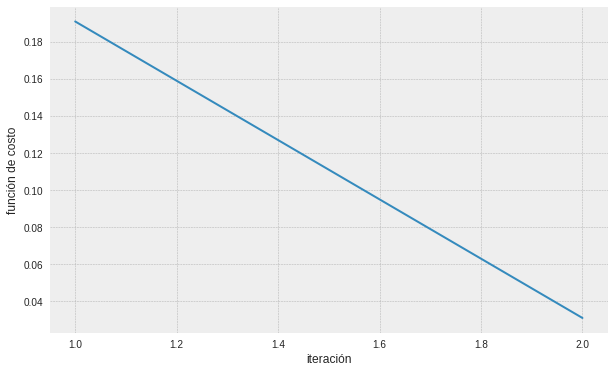

In [0]:
#@title Gráfico de función de costo en cada valor de T
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
rend_data = pd.DataFrame(rend)
plt.plot(rend_data.loc[:,"iteración"],rend_data.loc[:,"función de costo"])
plt.xlabel('iteración')
plt.ylabel('función de costo')
img_name = 'adanet-costo_' + adanet_perf.iloc[0,0] + '_' + experimento + '.png'
plt.savefig(img_name, bbox_inches='tight')
files.download(img_name)

Populating the interactive namespace from numpy and matplotlib


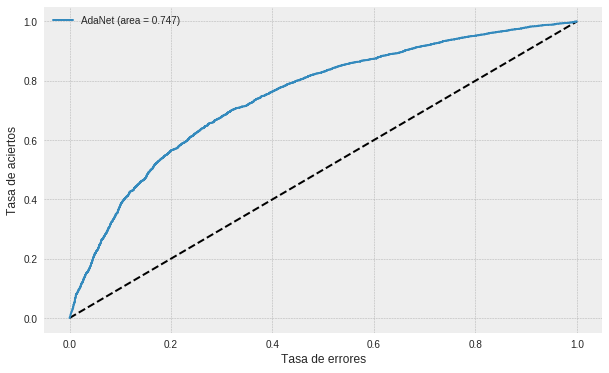

In [0]:
#@title Curva ROC de la clasificación 
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
y_pred_keras = model.predict(x_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='AdaNet (area = {:.3f})'.format(auc_keras))
plt.xlabel('Tasa de errores')
plt.ylabel('Tasa de aciertos')
plt.legend(loc='best')
img_name = 'adanet-roc_' + adanet_perf.iloc[0,0] + '_' + experimento + '.png'
plt.savefig(img_name, bbox_inches='tight')
files.download(img_name)

##### Cat and Dog

In [0]:
#@title Preprocesamiento
x_train, y_train, x_test, y_test = prep_cifar_binary(3,5,cifar_x_train,cifar_y_train,cifar_x_test,cifar_y_test)
print('última ejecución: ', str(datetime.now()))

/usr/local/lib/python3.6/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


última ejecución:  2018-05-21 18:05:37.705812


In [0]:
#@title Selección de muestra mediante 'held out data'
from sklearn.model_selection import train_test_split
x_all = np.append(x_train,x_test,axis=0)
y_all = np.append(y_train,y_test,axis=0)
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.7, random_state=42)
print('última ejecución: ', str(datetime.now()))

última ejecución:  2018-05-21 18:05:38.325304


In [0]:
#@title Entrenamiento de AdaNet
t1 = time.time()
model, rend = AdaNet(x_train,y_train,conf,verbose=0)
t2 = time.time()
t_training = t2-t1
print('última ejecución: ', str(datetime.now()))

última ejecución:  2018-05-21 18:07:38.957901


In [0]:
#@title Evaluación de AdaNet
t3 = time.time()
training_results = model.evaluate(x_test,y_test,verbose=0)
t4 = time.time()
t_inference = t4 - t3
print('última ejecución: ', str(datetime.now()))

última ejecución:  2018-05-21 18:07:41.885539


In [0]:
#@title Rendimiento de AdaBnn
min_v, max_v = conf_interval(len(y_test),training_results[1],0.95)
int_conv = "%.3f"%min(training_results[1] - min_v,max_v - training_results[1])
adanet_perf = pd.DataFrame({
    'par':'cat-dog',
    't. entrenamiento': "%.0f"%t_training,
    't. inferencia': "%.0f"%t_inference,
    '# parámetros': model.count_params(),
    'precisión': "%.3f"%training_results[1],
    'intervalo de confianza (95%)': int_conv
}, index=[0])
adanet_perf = adanet_perf.reindex(columns=['par','t. entrenamiento','t. inferencia','# parámetros','precisión','intervalo de confianza (95%)'])
adanet_perf

,par,t. entrenamiento,t. inferencia,# parámetros,precisión,intervalo de confianza (95%)
0,cat-dog,119,2,1765800,0.593,0.010


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['datetime', 'random', 'beta', 'concatenate']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


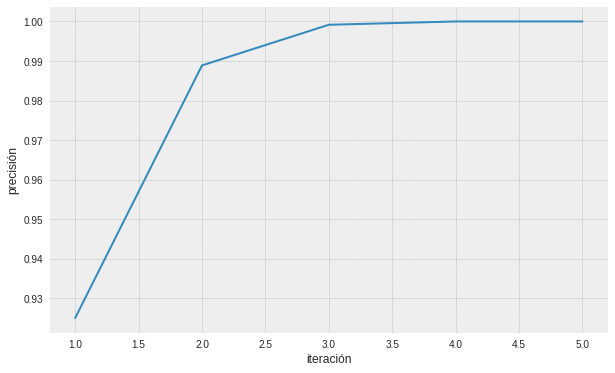

In [0]:
#@title Gráfico de precisión en cada valor de T
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
rend_data = pd.DataFrame(rend)
plt.plot(rend_data.loc[:,"iteración"],rend_data.loc[:,"precisión"])
plt.xlabel('iteración')
plt.ylabel('precisión')
img_name = 'adanet-precision_' + adanet_perf.iloc[0,0] + '_' + experimento + '.png'
plt.savefig(img_name, bbox_inches='tight')
files.download(img_name)

Populating the interactive namespace from numpy and matplotlib


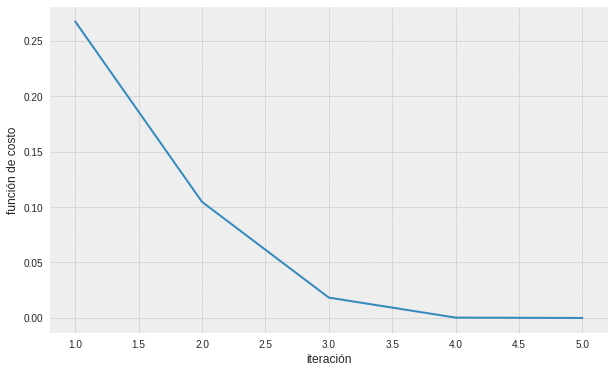

In [0]:
#@title Gráfico de función de costo en cada valor de T
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
rend_data = pd.DataFrame(rend)
plt.plot(rend_data.loc[:,"iteración"],rend_data.loc[:,"función de costo"])
plt.xlabel('iteración')
plt.ylabel('función de costo')
img_name = 'adanet-costo_' + adanet_perf.iloc[0,0] + '_' + experimento + '.png'
plt.savefig(img_name, bbox_inches='tight')
files.download(img_name)

Populating the interactive namespace from numpy and matplotlib


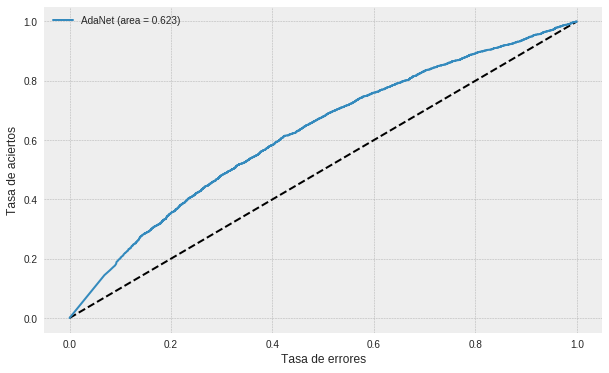

In [0]:
#@title Curva ROC de la clasificación 
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
y_pred_keras = model.predict(x_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='AdaNet (area = {:.3f})'.format(auc_keras))
plt.xlabel('Tasa de errores')
plt.ylabel('Tasa de aciertos')
plt.legend(loc='best')
img_name = 'adanet-roc_' + adanet_perf.iloc[0,0] + '_' + experimento + '.png'
plt.savefig(img_name, bbox_inches='tight')
files.download(img_name)

##### Dog and Horse

In [0]:
#@title Preprocesamiento
x_train, y_train, x_test, y_test = prep_cifar_binary(5,7,cifar_x_train,cifar_y_train,cifar_x_test,cifar_y_test)
print('última ejecución: ', str(datetime.now()))

/usr/local/lib/python3.6/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


última ejecución:  2018-05-21 18:17:48.076342


In [0]:
#@title Selección de muestra mediante 'held out data'
from sklearn.model_selection import train_test_split
x_all = np.append(x_train,x_test,axis=0)
y_all = np.append(y_train,y_test,axis=0)
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.7, random_state=42)
print('última ejecución: ', str(datetime.now()))

última ejecución:  2018-05-21 18:17:48.859501


In [0]:
#@title Entrenamiento de AdaNet
t1 = time.time()
model, rend = AdaNet(x_train,y_train,conf,verbose=0)
t2 = time.time()
t_training = t2-t1
print('última ejecución: ', str(datetime.now()))

última ejecución:  2018-05-21 18:18:42.984796


In [0]:
#@title Evaluación de AdaNet
t3 = time.time()
training_results = model.evaluate(x_test,y_test,verbose=0)
t4 = time.time()
t_inference = t4 - t3
print('última ejecución: ', str(datetime.now()))

última ejecución:  2018-05-21 18:18:44.864201


In [0]:
#@title Rendimiento de AdaNet
min_v, max_v = conf_interval(len(y_test),training_results[1],0.95)
int_conv = "%.3f"%min(training_results[1] - min_v,max_v - training_results[1])
adanet_perf = pd.DataFrame({
    'par':'dog-horse',
    't. entrenamiento': "%.0f"%t_training,
    't. inferencia': "%.0f"%t_inference,
    '# parámetros': model.count_params(),
    'precisión': "%.3f"%training_results[1],
    'intervalo de confianza (95%)': int_conv
}, index=[0])
adanet_perf = adanet_perf.reindex(columns=['par','t. entrenamiento','t. inferencia','# parámetros','precisión','intervalo de confianza (95%)'])
adanet_perf

,par,t. entrenamiento,t. inferencia,# parámetros,precisión,intervalo de confianza (95%)
0,dog-horse,53,1,556650,0.714,0.010


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['datetime', 'random', 'beta', 'concatenate']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


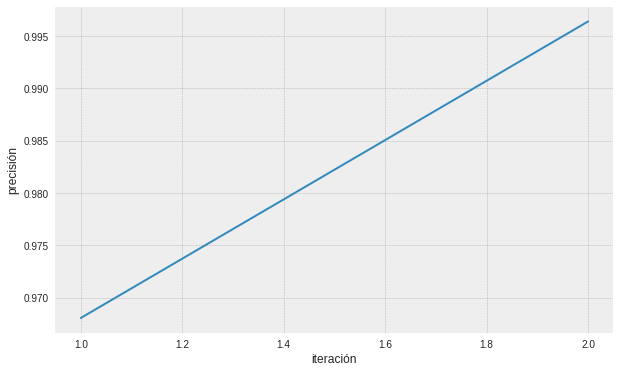

In [0]:
#@title Gráfico de precisión en cada valor de T
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
rend_data = pd.DataFrame(rend)
plt.plot(rend_data.loc[:,"iteración"],rend_data.loc[:,"precisión"])
plt.xlabel('iteración')
plt.ylabel('precisión')
img_name = 'adanet-precision_' + adanet_perf.iloc[0,0] + '_' + experimento + '.png'
plt.savefig(img_name, bbox_inches='tight')
files.download(img_name)

Populating the interactive namespace from numpy and matplotlib


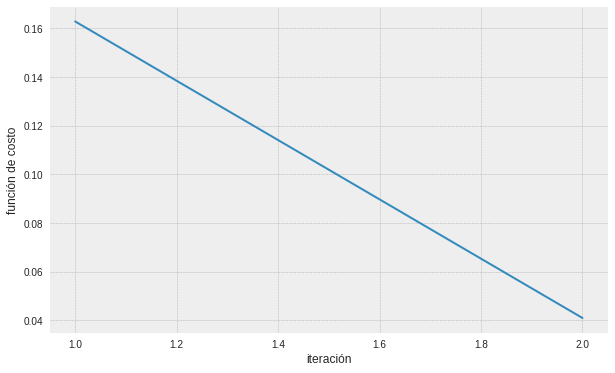

In [0]:
#@title Gráfico de función de costo en cada valor de T
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
rend_data = pd.DataFrame(rend)
plt.plot(rend_data.loc[:,"iteración"],rend_data.loc[:,"función de costo"])
plt.xlabel('iteración')
plt.ylabel('función de costo')
img_name = 'adanet-costo_' + adanet_perf.iloc[0,0] + '_' + experimento + '.png'
plt.savefig(img_name, bbox_inches='tight')
files.download(img_name)

Populating the interactive namespace from numpy and matplotlib


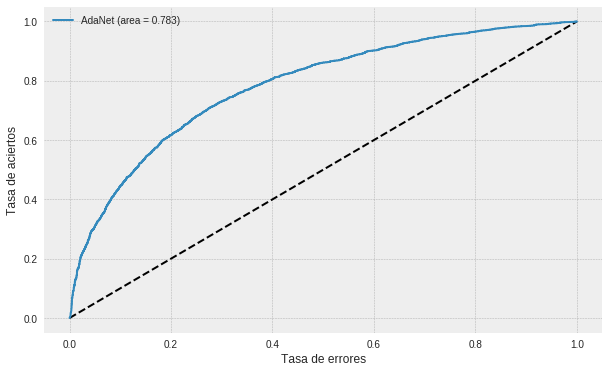

In [0]:
#@title Curva ROC de la clasificación 
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
y_pred_keras = model.predict(x_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='AdaNet (area = {:.3f})'.format(auc_keras))
plt.xlabel('Tasa de errores')
plt.ylabel('Tasa de aciertos')
plt.legend(loc='best')
img_name = 'adanet-roc_' + adanet_perf.iloc[0,0] + '_' + experimento + '.png'
plt.savefig(img_name, bbox_inches='tight')
files.download(img_name)

#### Clasificación multiclase

In [0]:
#@title Configuración de AdaNet
epochs = 50 #@param {type:"integer"}
B = 150 #@param {type:"integer"}
T = 2 #@param {type:"integer"}

conf = dict({
    'network': {
        'activation': 'relu',
        'output_activation': 'softmax',# softmax for multiple clases
        'optimizer': keras.optimizers.Adam(lr=0.0001),#opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
        'loss': 'categorical_crossentropy' # F for adanet traditional
        },
    'training':{
        'batch_size': 100,
        'epochs': epochs, #2,20
        },
    'adanet':{
        'B': B,#100
        'T': T,#5,15
        'delta': 1.01,
        'seed': 42
        }
    })
adanet_conf = pd.DataFrame({
    'función de costo': conf['network']['loss'],
    'función de optimización': str(conf['network']['optimizer'])[18:str(conf['network']['optimizer']).find(' ')],
    'observaciones por lote': conf['training']['batch_size'],
    'número de épocas': conf['training']['epochs'],
    'B': conf['adanet']['B'],
    'T': conf['adanet']['T']
}, index=[0])
adanet_conf = adanet_conf.reindex(columns=['B','T','función de costo','función de optimización','observaciones por lote','número de épocas'])
experimento = '_'.join([str(j) for j in adanet_conf.iloc[0,:]])
adanet_conf

,B,T,función de costo,función de optimización,observaciones por lote,número de épocas
0,150,2,categorical_crossentropy,Adam,100,50


In [0]:
#@title Preprocesamiento
x_train, y_train, x_test, y_test = prep_cifar_multi(cifar_x_train,cifar_y_train,cifar_x_test,cifar_y_test)
print('última ejecución: ', str(datetime.now()))

/usr/local/lib/python3.6/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


última ejecución:  2018-05-21 18:43:49.953968


In [0]:
#@title Selección de muestra mediante 'held out data'
from sklearn.model_selection import train_test_split
x_all = np.append(x_train,x_test,axis=0)
y_all = np.append(y_train,y_test,axis=0)
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.7, random_state=42)
print('última ejecución: ', str(datetime.now()))

última ejecución:  2018-05-21 18:43:51.090189


In [0]:
#@title Entrenamiento de AdaNet
t1 = time.time()
model, rend = AdaNet(x_train,y_train,conf,verbose=0,classes=10)
t2 = time.time()
t_training = t2-t1
print('última ejecución: ', str(datetime.now()))

última ejecución:  2018-05-21 18:48:53.274851


In [0]:
#@title Evaluación de AdaNet
t3 = time.time()
training_results = model.evaluate(x_test,y_test,verbose=0)
t4 = time.time()
t_inference = t4 - t3
print('última ejecución: ', str(datetime.now()))

última ejecución:  2018-05-21 18:48:59.607960


In [0]:
#@title Rendimiento de AdaNet
min_v, max_v = conf_interval(len(y_test),training_results[1],0.95)
int_conv = "%.3f"%min(training_results[1] - min_v,max_v - training_results[1])
adanet_perf = pd.DataFrame({
    'par':'todos',
    't. entrenamiento': "%.0f"%t_training,
    't. inferencia': "%.0f"%t_inference,
    '# parámetros': model.count_params(),
    'precisión': "%.3f"%training_results[1],
    'intervalo de confianza (95%)': int_conv
}, index=[0])
adanet_perf = adanet_perf.reindex(columns=['par','t. entrenamiento','t. inferencia','# parámetros','precisión','intervalo de confianza (95%)'])
adanet_perf

,par,t. entrenamiento,t. inferencia,# parámetros,precisión,intervalo de confianza (95%)
0,todos,301,5,560700,0.430,0.005


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['datetime', 'random', 'beta', 'concatenate']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


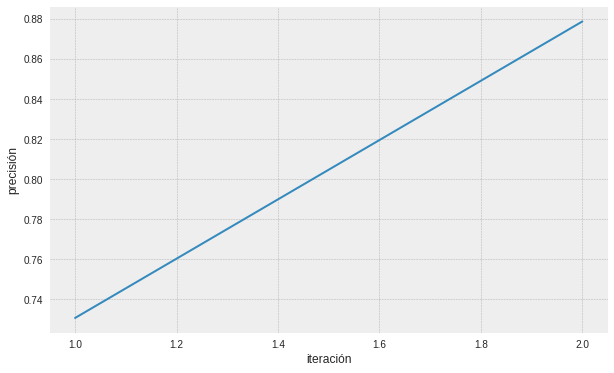

In [0]:
#@title Gráfico de precisión en cada valor de T
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
rend_data = pd.DataFrame(rend)
plt.plot(rend_data.loc[:,"iteración"],rend_data.loc[:,"precisión"])
plt.xlabel('iteración')
plt.ylabel('precisión')
img_name = 'adanet-precision_' + adanet_perf.iloc[0,0] + '_' + experimento + '.png'
plt.savefig(img_name, bbox_inches='tight')
files.download(img_name)

Populating the interactive namespace from numpy and matplotlib


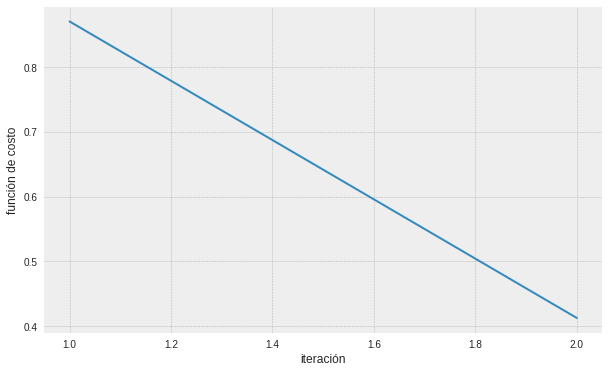

In [0]:
#@title Gráfico de función de costo en cada valor de T
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
rend_data = pd.DataFrame(rend)
plt.plot(rend_data.loc[:,"iteración"],rend_data.loc[:,"función de costo"])
plt.xlabel('iteración')
plt.ylabel('función de costo')
img_name = 'adanet-costo_' + adanet_perf.iloc[0,0] + '_' + experimento + '.png'
plt.savefig(img_name, bbox_inches='tight')
files.download(img_name)

### Experimentos con MNIST

In [0]:
#@title Configuración de AdaNet
epochs = 25 #@param {type:"integer"}
B = 150 #@param {type:"integer"}
T = 2 #@param {type:"integer"}
conf = dict({
    'network': {
        'activation': 'relu',
        'output_activation': 'softmax',# softmax for multiple clases
        'optimizer': keras.optimizers.Adam(lr=0.0001),#opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
        'loss': 'categorical_crossentropy' # F for adanet traditional
        },
    'training':{
        'batch_size': 100,
        'epochs': epochs,#2,20
        },
    'adanet':{
        'B': B,#100
        'T': T,#5,15
        'delta': 1.01,
        'seed': 42
        }
    })
adanet_conf = pd.DataFrame({
    'función de costo': conf['network']['loss'],
    'función de optimización': str(conf['network']['optimizer'])[18:str(conf['network']['optimizer']).find(' ')],
    'observaciones por lote': conf['training']['batch_size'],
    'número de épocas': conf['training']['epochs'],
    'B': conf['adanet']['B'],
    'T': conf['adanet']['T']
}, index=[0])
adanet_conf = adanet_conf.reindex(columns=['B','T','función de costo','función de optimización','observaciones por lote','número de épocas'])
experimento = '_'.join([str(j) for j in adanet_conf.iloc[0,:]])
adanet_conf

,B,T,función de costo,función de optimización,observaciones por lote,número de épocas
0,150,2,categorical_crossentropy,Adam,100,25


In [0]:
#@title Preprocesamiento 
x_train, y_train, x_test, y_test = prep_mnist_multi(mnist_x_train,mnist_y_train,mnist_x_test,mnist_y_test)
print('última ejecución: ', str(datetime.now()))

última ejecución:  2018-05-21 19:29:52.520041


In [0]:
#@title Selección de muestra mediante 'held out data'
from sklearn.model_selection import train_test_split
x_all = np.append(x_train,x_test,axis=0)
y_all = np.append(y_train,y_test,axis=0)
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.7, random_state=42)
print('última ejecución: ', str(datetime.now()))

última ejecución:  2018-05-21 19:29:53.527957


In [0]:
#@title Entrenamiento de AdaNet
t1 = time.time()
model, rend = AdaNet(x_train,y_train,conf,verbose=0,classes=10)
t2 = time.time()
t_training = t2-t1
print('última ejecución: ', str(datetime.now()))

última ejecución:  2018-05-21 19:33:44.795081


In [0]:
#@title Evaluación de AdaNet
t3 = time.time()
training_results = model.evaluate(x_test,y_test,verbose=0)
t4 = time.time()
t_inference = t4 - t3
print('última ejecución: ', str(datetime.now()))

última ejecución:  2018-05-21 19:33:51.845539


In [0]:
#@title Rendimiento de AdaNet
min_v, max_v = conf_interval(len(y_test),training_results[1],0.95)
int_conv = "%.3f"%min(training_results[1] - min_v,max_v - training_results[1])
adanet_perf = pd.DataFrame({
    'par':'mnist',
    't. entrenamiento': "%.0f"%t_training,
    't. inferencia': "%.0f"%t_inference,
    '# parámetros': model.count_params(),
    'precisión': "%.3f"%training_results[1],
    'intervalo de confianza (95%)': int_conv
}, index=[0])
adanet_perf = adanet_perf.reindex(columns=['par','t. entrenamiento','t. inferencia','# parámetros','precisión','intervalo de confianza (95%)'])
adanet_perf

,par,t. entrenamiento,t. inferencia,# parámetros,precisión,intervalo de confianza (95%)
0,mnist,230,6,537300,0.970,0.001


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['datetime', 'random', 'beta', 'concatenate']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


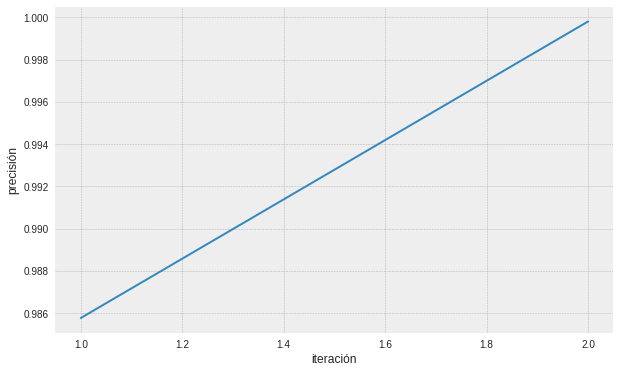

In [0]:
#@title Gráfico de precisión en cada valor de T
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
rend_data = pd.DataFrame(rend)
plt.plot(rend_data.loc[:,"iteración"],rend_data.loc[:,"precisión"])
plt.xlabel('iteración')
plt.ylabel('precisión')
img_name = 'adanet-precision_' + adanet_perf.iloc[0,0] + '_' + experimento + '.png'
plt.savefig(img_name, bbox_inches='tight')
files.download(img_name)

Populating the interactive namespace from numpy and matplotlib


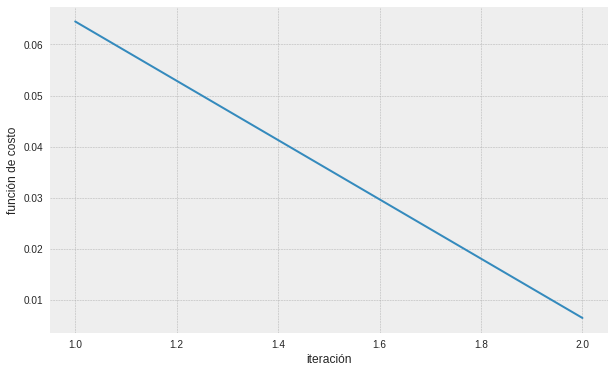

In [0]:
#@title Gráfico de función de costo en cada valor de T
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
rend_data = pd.DataFrame(rend)
plt.plot(rend_data.loc[:,"iteración"],rend_data.loc[:,"función de costo"])
plt.xlabel('iteración')
plt.ylabel('función de costo')
img_name = 'adanet-costo_' + adanet_perf.iloc[0,0] + '_' + experimento + '.png'
plt.savefig(img_name, bbox_inches='tight')
files.download(img_name)